# <center style="color: #003b7f"> Analyzing Temperature and Precipitation Patterns <br/> for Climate Assessment </center> <a class='tocSkip'>

**MSDS 2023 Term 4 SLT1B** | Loraine Menorca, BJ Enrik Yepes
    
This notebook serves as a supplementary resource to provide comprehensive details about the queries pertaining to the tables and plots in the main notebook. It is designed to complement both the main notebook and the data preparation notebook.
    
**! Note:** This was ran using PySpark via AWS' EMR studio. Rerunning the entire notebook outside a similar environment is not advisable.
    
***   

# Spark Initialization, Imports, and Packages

To begin, we initialize Spark and import the necessary functions from the PySpark library.

In [1]:
spark

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1686497991926_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
from pyspark.sql.functions import (
    col,
    desc,
    sum,
    expr
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now, as this is a new notebook, we must install the required packages for our code. In our case, we will need the following packages:

- `numpy` and `pandas` for data preprocessing tasks.
- `fsspec` and `s3fs` for saving the aggregated data.
- `matplotlib` for visualizing the aggregated dataframes during testing.

In [4]:
sc.install_pypi_package('numpy')
sc.install_pypi_package('pandas')
sc.install_pypi_package('fsspec')
sc.install_pypi_package('s3fs ')
sc.install_pypi_package('matplotlib')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Loading the Data

Next, we proceed to load the required files. In this step, we will load both the raw data in CSV format and the preprocessed data in Parquet format.

In [70]:
fpath = 's3://bdcc-lab2-2023/ghcnd/processed/cleaned/ghcnd_cleaned_2023-06-11_10:37.parquet/'
fpath_all = 's3://noaa-ghcn-pds/csv/by_year/20*'

df = spark.read.parquet(fpath, header=True, inferSchema=True)
df_all = spark.read.csv('s3://noaa-ghcn-pds/csv/by_year/20*', header=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Shape and Null Values

Next, we obtain the shape and count of null values for both the raw data and the preprocessed data.

## Raw Data

In [6]:
num_rows = df_all.count()  # Count the number of rows
num_cols = len(df_all.columns)  # Get the number of columns

print("Number of rows: ", num_rows)
print("Number of columns: ", num_cols)

# Create a DataFrame with the number of rows and columns
shape_data = [(num_rows, num_cols)]
shape_schema = "num_rows LONG, num_cols INT"
shape_df_all = spark.createDataFrame(shape_data, shape_schema).cache()

# Show the shape DataFrame
shape_df_all.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of rows:  872488410
Number of columns:  8
+---------+--------+
| num_rows|num_cols|
+---------+--------+
|872488410|       8|
+---------+--------+

In [7]:
null_counts_all = df_all.select([sum(col(column).isNull().cast('int')).alias(column) for column in df_all.columns]).cache()

# Define the column names and values
column_1 = null_counts_all.columns
column_2 = list(null_counts_all.collect()[0].asDict().values())

# Combine the column names and values using zip
data_null_all = zip(column_1, column_2)

# Create the DataFrame
null_count_df_all = spark.createDataFrame(data_null_all, schema=["Column Name", "Null Values"]).cache()
null_count_df_all.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-----------+
|Column Name|Null Values|
+-----------+-----------+
|         ID|          0|
|       DATE|          0|
|    ELEMENT|          0|
| DATA_VALUE|          0|
|     M_FLAG|  763562307|
|     Q_FLAG|  869921702|
|     S_FLAG|          0|
|   OBS_TIME|  542603408|
+-----------+-----------+

## Preprocessed Data

In [14]:
num_rows = df.count()  # Count the number of rows
num_cols = len(df.columns)  # Get the number of columns

print("Number of rows: ", num_rows)
print("Number of columns: ", num_cols)

# Create a DataFrame with the number of rows and columns
shape_data = [(num_rows, num_cols)]
shape_schema = "num_rows LONG, num_cols INT"
shape_df = spark.createDataFrame(shape_data, shape_schema).cache()

# Show the shape DataFrame
shape_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of rows:  259425097
Number of columns:  19
+---------+--------+
| num_rows|num_cols|
+---------+--------+
|259425097|      19|
+---------+--------+

In [15]:
null_counts = df.select([sum(col(column).isNull().cast('int')).alias(column) for column in df.columns]).cache()

# Define the column names and values
column_1 = null_counts.columns
column_2 = list(null_counts.collect()[0].asDict().values())

# Combine the column names and values using zip
data_null = zip(column_1, column_2)

# Create the DataFrame
null_count_df = spark.createDataFrame(data_null, schema=["Column Name", "Null Values"]).cache()
null_count_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+-----------+
| Column Name|Null Values|
+------------+-----------+
|          ID|          0|
|        DATE|          0|
|      M_FLAG|  243675532|
|      Q_FLAG|  259425097|
|      S_FLAG|          0|
|    OBS_TIME|  134640716|
|        PRCP|   22673906|
|        TMAX|  134563271|
|        TAVG|  212257472|
|        TMIN|  135570488|
|COUNTRY_CODE|          0|
|       STATE|  235551938|
|    LATITUDE|  116589633|
|   LONGITUDE|  127955322|
|        YEAR|          0|
|       MONTH|          0|
|         DAY|          0|
|     COUNTRY|          0|
| HOUR_OF_DAY|  134640716|
+------------+-----------+

To enhance loading times and streamline execution in our main notebook, we choose to save the aggregates as CSV files.

In [16]:
# Define the output paths for saving the dataframes
output_path_shape_df = "s3://bdcc-lab2-2023/ghcnd/extracted_csv/shape_df.csv"
output_path_shape_df_all = "s3://bdcc-lab2-2023/ghcnd/extracted_csv/shape_df_all.csv"
output_path_null_counts = "s3://bdcc-lab2-2023/ghcnd/extracted_csv/null_counts.csv"
output_path_null_counts_all = "s3://bdcc-lab2-2023/ghcnd/extracted_csv/null_counts_all.csv"

# Save null_counts as CSV
shape_df.toPandas().to_csv(output_path_shape_df, header=True, index=False)
shape_df_all.toPandas().to_csv(output_path_shape_df_all, header=True, index=False)
null_count_df.toPandas().to_csv(output_path_null_counts, header=True, index=False)
null_count_df_all.toPandas().to_csv(output_path_null_counts_all, header=True, index=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Quick Statistic

Next, we calculate quick statistics for both the raw data and the preprocessed data.

In [24]:
# Specify the fraction of data to include in the sample (e.g., 10%)
sample_fraction = 0.001

# Take a sample of the DataFrame
sample_df_all = df_all.sample(withReplacement=False, fraction=sample_fraction)

# Perform descriptive analytics on the sample using describe()
df_all_describe = sample_df_all.describe().cache()

df_all_describe.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------+--------------------+-------+------------------+------+------+-----------------+-----------------+
|summary|         ID|                DATE|ELEMENT|        DATA_VALUE|M_FLAG|Q_FLAG|           S_FLAG|         OBS_TIME|
+-------+-----------+--------------------+-------+------------------+------+------+-----------------+-----------------+
|  count|     873039|              873039| 873039|            873039|109032|  2560|           873039|           329976|
|   mean|       null|2.0112882823673397E7|   null|153.05760681939753|  null|  null|3.011585600055868|963.6564659247945|
| stddev|       null|   66971.35848288266|   null| 840.3386975725879|  null|  null|3.465751067717828|519.5935332652722|
|    min|AE000041196|            20000101|   ACMH|                -1|     B|     D|                0|             0000|
|    max|ZI000067983|            20230609|   WV20|              9999|     T|     Z|                z|             2400|
+-------+-----------+-------------------

In [22]:
# Specify the fraction of data to include in the sample (e.g., 10%)
sample_fraction = 0.001

# Take a sample of the DataFrame
sample_df = df.sample(withReplacement=False, fraction=sample_fraction)

# Perform descriptive analytics on the sample using describe()
df_describe = sample_df.describe().cache()

df_describe.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------+------+------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------+------------------+-----------------+-------------------+------------------+------------------+------------------+--------+-----------------+
|summary|         ID|M_FLAG|Q_FLAG|            S_FLAG|         OBS_TIME|              PRCP|              TMAX|              TAVG|             TMIN|COUNTRY_CODE|             STATE|         LATITUDE|          LONGITUDE|              YEAR|             MONTH|               DAY| COUNTRY|      HOUR_OF_DAY|
+-------+-----------+------+------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------+------------------+-----------------+-------------------+------------------+------------------+------------------+--------+-----------------+
|  count|     258404| 16091|     0|            258404|           124207|            235526|   

In [123]:
# Define the output paths for saving the dataframes
output_path_describe_df = "s3://bdcc-lab2-2023/ghcnd/extracted_csv/quick_stats/describe_df.csv"
output_path_describe_all = "s3://bdcc-lab2-2023/ghcnd/extracted_csv/quick_stats/describe_df_all.csv"

# Save null_counts as CSV
df_describe.toPandas().to_csv(output_path_describe_df, header=True, index=False)
df_all_describe.toPandas().to_csv(output_path_describe_all, header=True, index=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Univariate Analysis Plots

Next, we proceed to perform univariate analysis on our preprocessed data. This analysis aims to showcase the individual characteristics of each variable in isolation.

## Precipitation

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

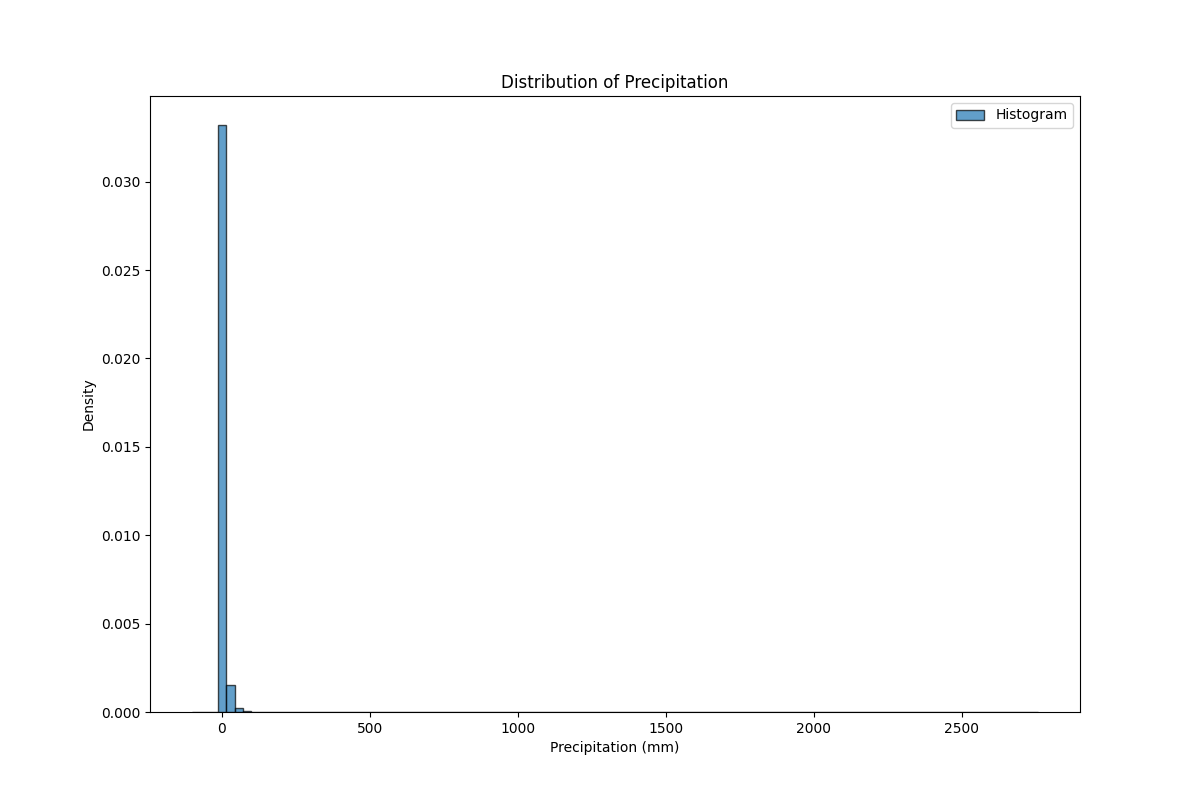

In [49]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter out null values in the PRCP column
filtered_df = df.filter(df["PRCP"].isNotNull())

# Convert the PRCP column to float
filtered_df = filtered_df.withColumn("PRCP", filtered_df["PRCP"].cast("float"))

# Get a 10% sample of the PRCP values
sampled_df = filtered_df.select("PRCP").sample(withReplacement=False, fraction=0.1, seed=42)

# Get the PRCP values as a list
prcp_values = sampled_df.rdd.flatMap(lambda x: x).collect()

# Plot the histogram with KDE line
plt.figure(figsize=(12, 8))
hist_prcp, bins_prcp, _ = plt.hist(prcp_values, bins=100, edgecolor='black', density=True, alpha=0.7, label="Histogram")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Density")
plt.title("Distribution of Precipitation")
plt.legend()
plt.show()

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

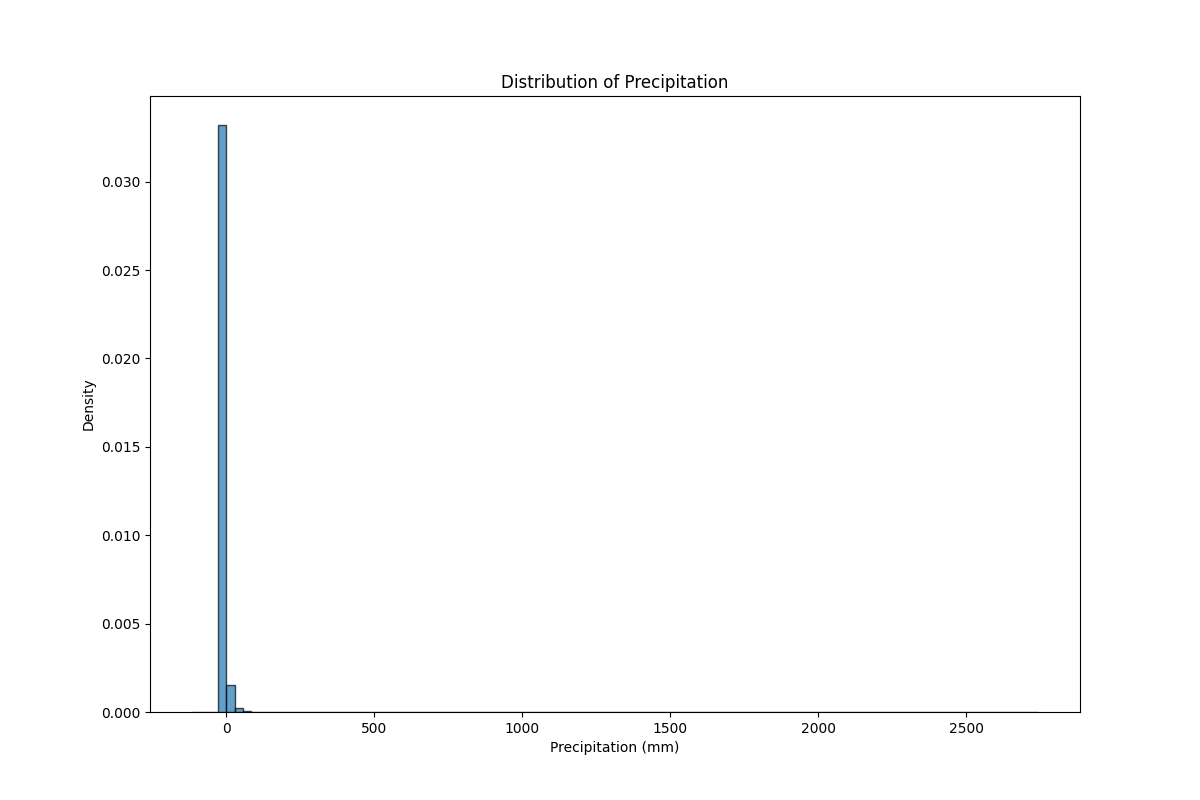

In [59]:

# Create a DataFrame from hist and bins
histogram_prcp = pd.DataFrame({
    'Bins': bins_prcp[:-1],
    'Count': hist_prcp
})

# Plot the histogram using the DataFrame
plt.figure(figsize=(12, 8))
plt.bar(histogram_prcp['Bins'], histogram_prcp['Count'], width=histogram_prcp['Bins'][1] - histogram_prcp['Bins'][0], edgecolor='black', alpha=0.7)
plt.xlabel('Precipitation (mm)')
plt.ylabel('Density')
plt.title('Distribution of Precipitation')

plt.show()

%matplot plt

## Maximum Temperature

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

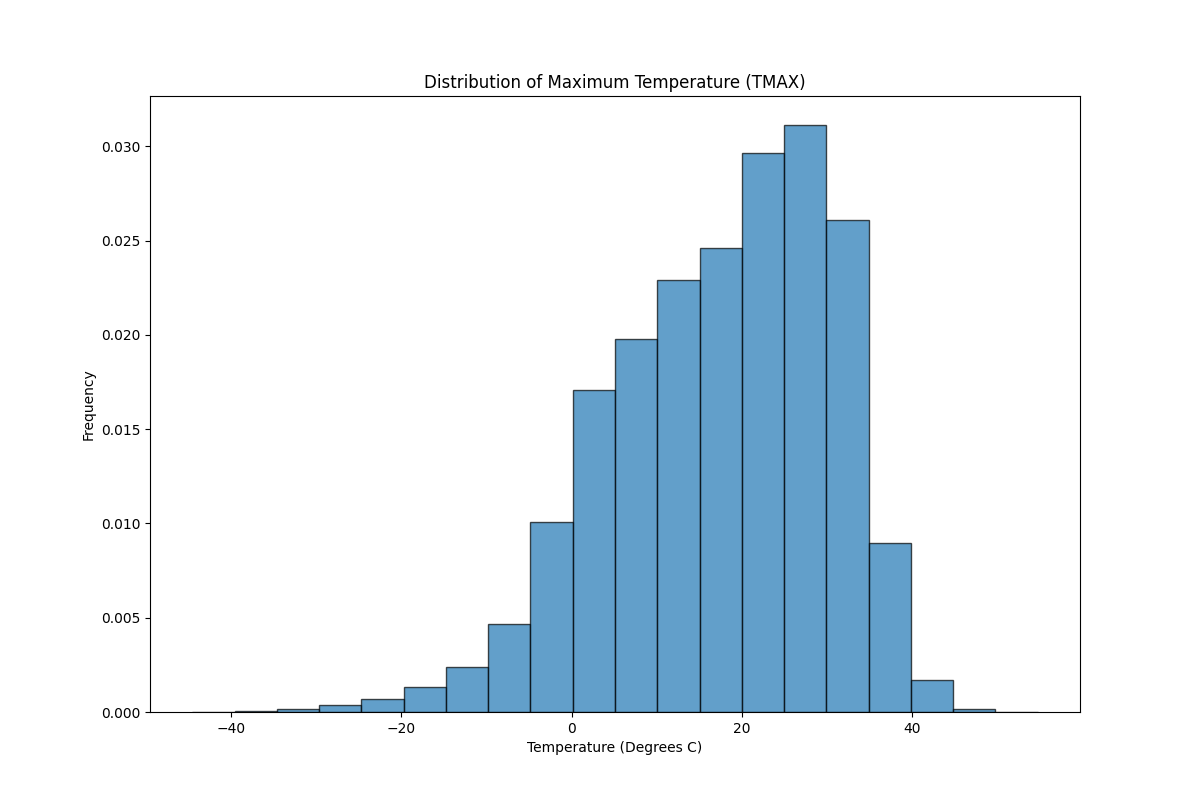

In [58]:
# Filter out null values in the PRCP column
filtered_df = df.filter(df["TMAX"].isNotNull())

# Sample 10% of TMAX column
sampled_tmax_df = filtered_df.select("TMAX").sample(withReplacement=False, fraction=0.1, seed=42)
tmax_values = sampled_tmax_df.rdd.flatMap(lambda x: x).collect()

# Plot histogram for TMAX
plt.figure(figsize=(12, 8))
hist_tmax, bins_tmax, _ = plt.hist(tmax_values, bins=20, edgecolor='black', density=True, alpha=0.7, label="Histogram")
plt.xlabel('Temperature (Degrees C)')
plt.ylabel('Frequency')
plt.title('Distribution of Maximum Temperature (TMAX)')
plt.show()

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

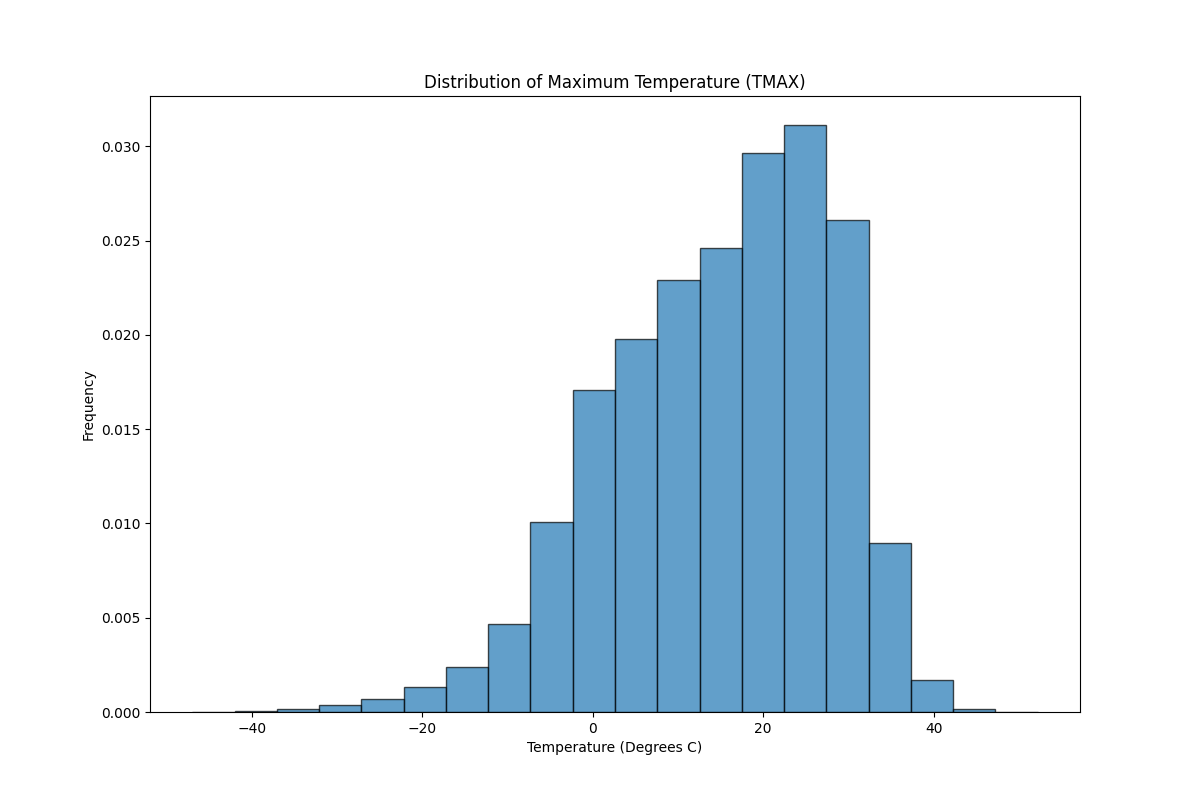

In [60]:

# Create a DataFrame from hist and bins
histogram_tmax = pd.DataFrame({
    'Bins': bins_tmax[:-1],
    'Count': hist_tmax
})

# Plot the histogram using the DataFrame
plt.figure(figsize=(12, 8))
plt.bar(histogram_tmax['Bins'], histogram_tmax['Count'], width=histogram_tmax['Bins'][1] - histogram_tmax['Bins'][0], edgecolor='black', alpha=0.7)
plt.xlabel('Temperature (Degrees C)')
plt.ylabel('Frequency')
plt.title('Distribution of Maximum Temperature (TMAX)')

plt.show()

%matplot plt

## Minimum Temperature

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

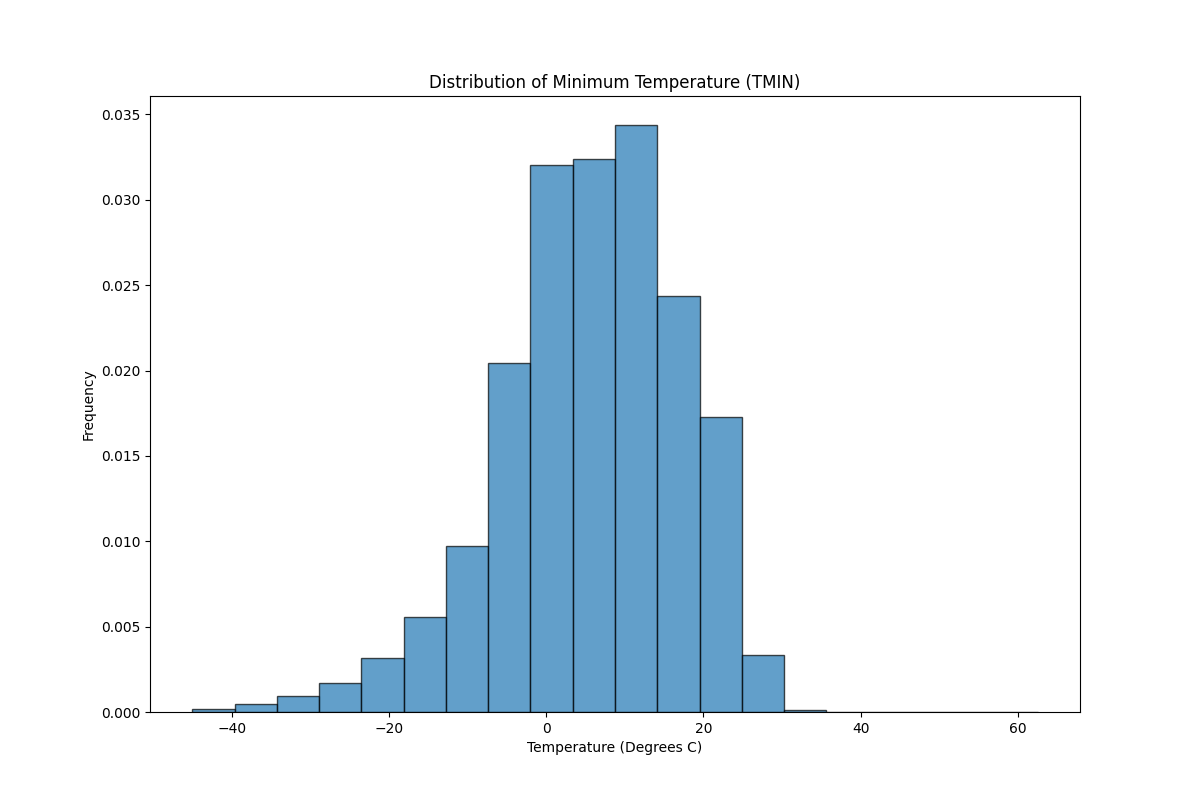

In [61]:
# Filter out null values in the PRCP column
filtered_df = df.filter(df["TMIN"].isNotNull())

# Sample 10% of TMIN column
sampled_tmin_df = filtered_df.select("TMIN").sample(withReplacement=False, fraction=0.1, seed=42)
tmin_values = sampled_tmin_df.rdd.flatMap(lambda x: x).collect()

# Plot histogram for TMIN
plt.figure(figsize=(12, 8))
hist_tmin, bins_tmin, _ = plt.hist(tmin_values, bins=20, edgecolor='black', density=True, alpha=0.7, label="Histogram")
plt.xlabel('Temperature (Degrees C)')
plt.ylabel('Frequency')
plt.title('Distribution of Minimum Temperature (TMIN)')
plt.show()

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

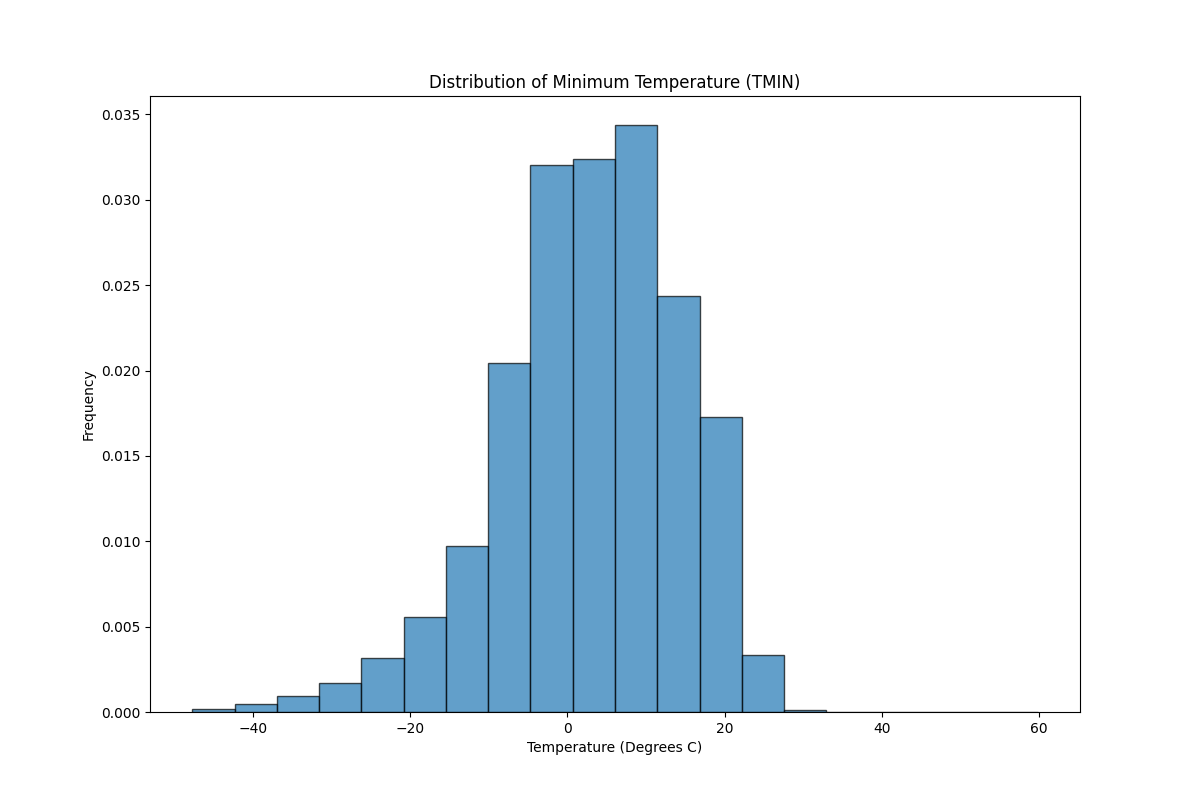

In [62]:

# Create a DataFrame from hist and bins
histogram_tmin = pd.DataFrame({
    'Bins': bins_tmin[:-1],
    'Count': hist_tmin
})

# Plot the histogram using the DataFrame
plt.figure(figsize=(12, 8))
plt.bar(histogram_tmin['Bins'], histogram_tmin['Count'], width=histogram_tmin['Bins'][1] - histogram_tmin['Bins'][0], edgecolor='black', alpha=0.7)
plt.xlabel('Temperature (Degrees C)')
plt.ylabel('Frequency')
plt.title('Distribution of Minimum Temperature (TMIN)')

plt.show()

%matplot plt

## Country

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

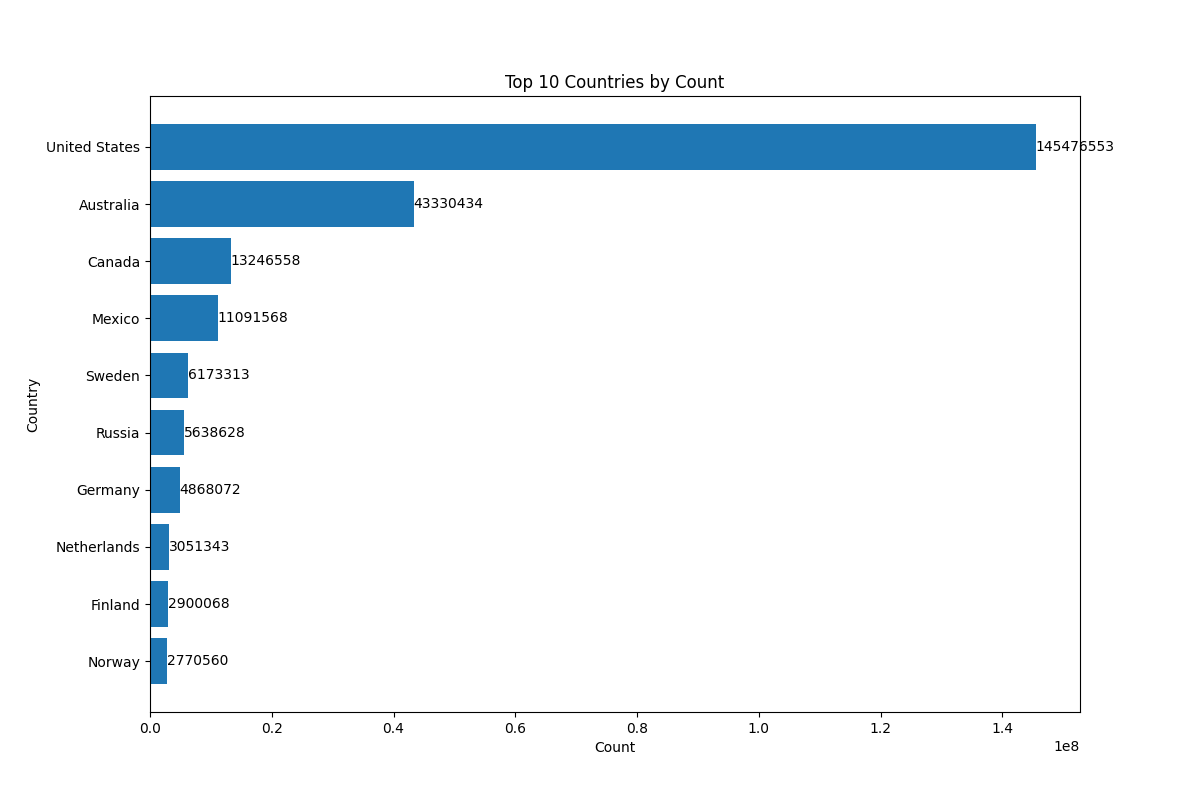

In [64]:
# Group the data by country and count the occurrences
country_counts = df.groupBy("COUNTRY").count()

# Sort the counts in descending order
sorted_country_counts = country_counts.orderBy("count", ascending=False)

# Select the top 10 countries by count
top_10_countries = sorted_country_counts.limit(10)

# Extract the country names and counts
countries = [row["COUNTRY"] for row in top_10_countries.collect()][::-1]
counts = [row["count"] for row in top_10_countries.collect()][::-1]

# Create the horizontal bar plot
plt.figure(figsize=(12, 8))
plt.barh(countries, counts)
plt.xlabel("Count")
plt.ylabel("Country")
plt.title("Top 10 Countries by Count")

# Add data labels to the bars
for i, count in enumerate(counts):
    plt.text(count, i, str(count), ha="left", va="center")

plt.show()

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

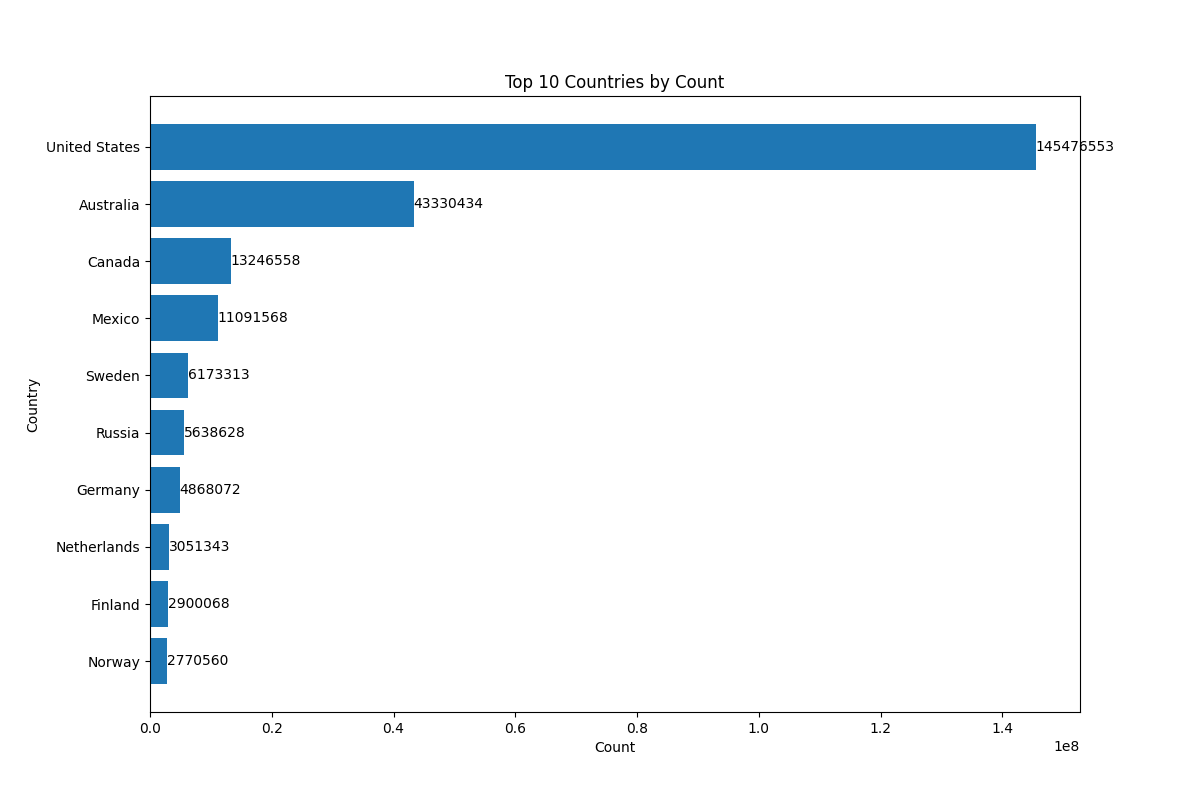

In [67]:
# Create a pandas DataFrame from countries and counts
country_count_dict = {"Country": countries, "Count": counts}
country_count_df = pd.DataFrame(country_count_dict)

# Visualize the DataFrame
plt.figure(figsize=(12, 8))
plt.barh(country_count_df["Country"], country_count_df["Count"])
plt.xlabel("Count")
plt.ylabel("Country")
plt.title("Top 10 Countries by Count")

# Add data labels to the bars
for i, count in enumerate(df["Count"]):
    plt.text(count, i, str(count), ha="left", va="center")

plt.show()

%matplot plt

## Year

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

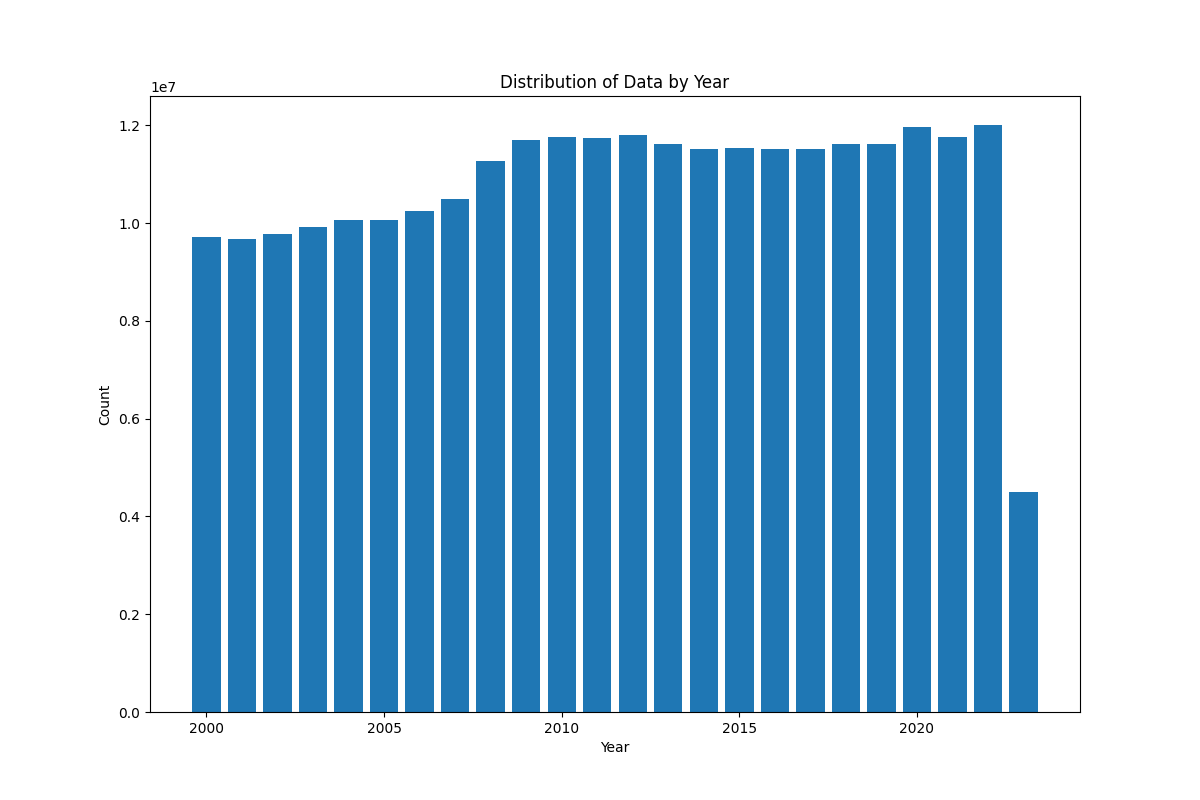

In [71]:
# Group by "YEAR" and count the occurrences
year_counts = df.groupBy("YEAR").count().orderBy("YEAR").toPandas()

# Create a histogram for "YEAR" counts
plt.figure(figsize=(12, 8))
plt.bar(year_counts["YEAR"], year_counts["count"])
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Distribution of Data by Year")
plt.show()

%matplot plt

## Month

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

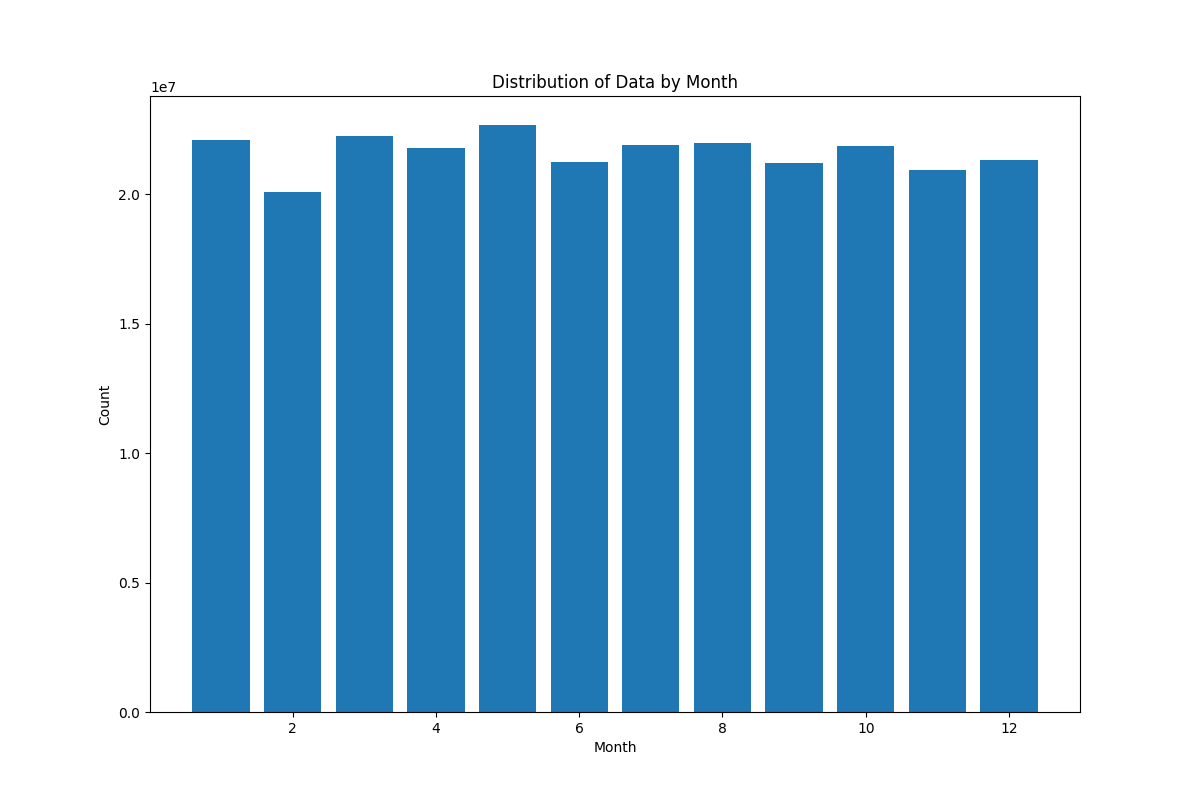

In [74]:
# Group by "MONTH" and count the occurrences
month_counts = df.groupBy("MONTH").count().orderBy("MONTH").toPandas()

# Create a histogram for "MONTH" counts
plt.figure(figsize=(12, 8))
plt.bar(month_counts["MONTH"], month_counts["count"])
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Distribution of Data by Month")
plt.show()

%matplot plt

## Day

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

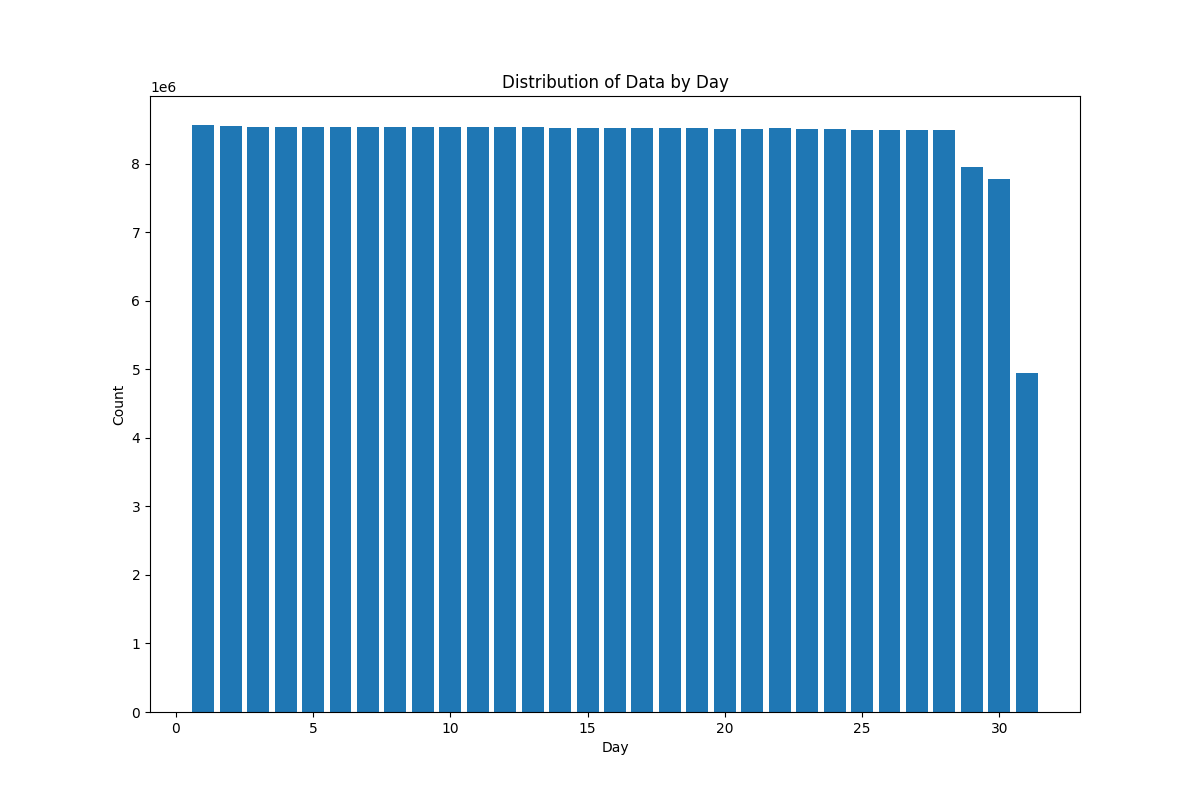

In [78]:
# Group by "DAY" and count the occurrences
day_counts = df.groupBy("DAY").count().orderBy("DAY").toPandas()

# Create a histogram for "DAY" counts
plt.figure(figsize=(12, 8))
plt.bar(day_counts["DAY"], day_counts["count"])
plt.xlabel("Day")
plt.ylabel("Count")
plt.title("Distribution of Data by Day")
plt.show()

%matplot plt

## Saving the Plot Dataframes

In [79]:
output_path_histogram_prcp = "s3://bdcc-lab2-2023/ghcnd/extracted_csv/histogram_prcp.csv"
output_path_histogram_tmax = "s3://bdcc-lab2-2023/ghcnd/extracted_csv/histogram_tmax.csv"
output_path_histogram_tmin = "s3://bdcc-lab2-2023/ghcnd/extracted_csv/histogram_tmin.csv"
output_path_country_count = "s3://bdcc-lab2-2023/ghcnd/extracted_csv/country_count_df.csv"
output_path_year_counts = "s3://bdcc-lab2-2023/ghcnd/extracted_csv/year_counts.csv"
output_path_month_counts = "s3://bdcc-lab2-2023/ghcnd/extracted_csv/month_counts.csv"
output_path_day_counts = "s3://bdcc-lab2-2023/ghcnd/extracted_csv/day_counts.csv"

histogram_prcp.to_csv(output_path_histogram_prcp, index=False)
histogram_tmax.to_csv(output_path_histogram_tmax, index=False)
histogram_tmin.to_csv(output_path_histogram_tmin, index=False)
country_count_df.to_csv(output_path_country_count, index=False)
year_counts.to_csv(output_path_year_counts, index=False)
month_counts.to_csv(output_path_month_counts, index=False)
day_counts.to_csv(output_path_day_counts, index=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Bivariate Analysis Plots

Next, we proceed to perform bivariate analysis. Bivariate analysis involves examining the relationship between two variables to uncover any patterns, associations, or dependencies between them. This analysis helps us gain insights into how the variables interact with each other and how they collectively impact the data analysis process.

## Maximum Temperature vs Minimum Temperature

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

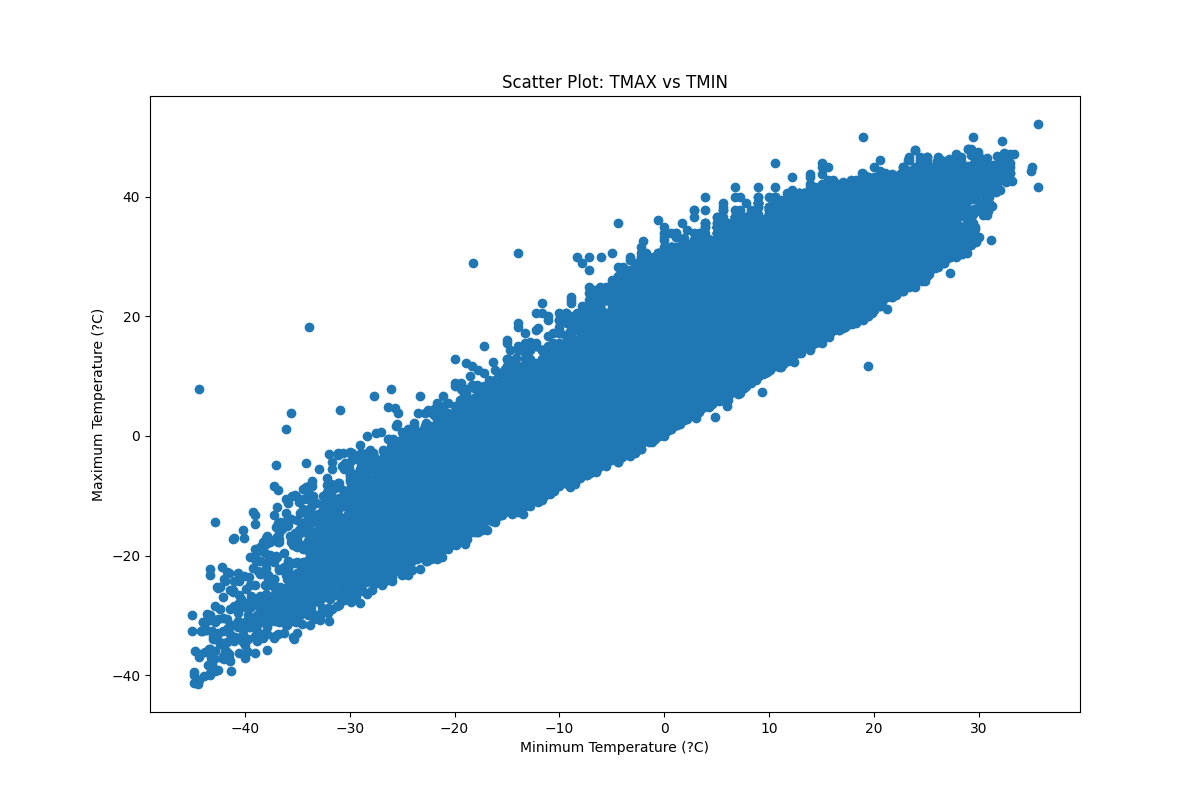

In [80]:
# Select the columns for bivariate analysis
tmax_tmin_data = df.select("TMAX", "TMIN")

# Sample a portion of the data for plotting
sampled_data = tmax_tmin_data.sample(withReplacement=False, fraction=0.001, seed=42)

# Collect the sampled data as lists
tmin_values = sampled_data.select("TMIN").rdd.flatMap(lambda x: x).collect()
tmax_values = sampled_data.select("TMAX").rdd.flatMap(lambda x: x).collect()

# Plotting TMAX vs TMIN
plt.figure(figsize=(12, 8))
plt.scatter(tmin_values, tmax_values)
plt.xlabel("Minimum Temperature (°C)")
plt.ylabel("Maximum Temperature (°C)")
plt.title("Scatter Plot: TMAX vs TMIN")

plt.show()

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

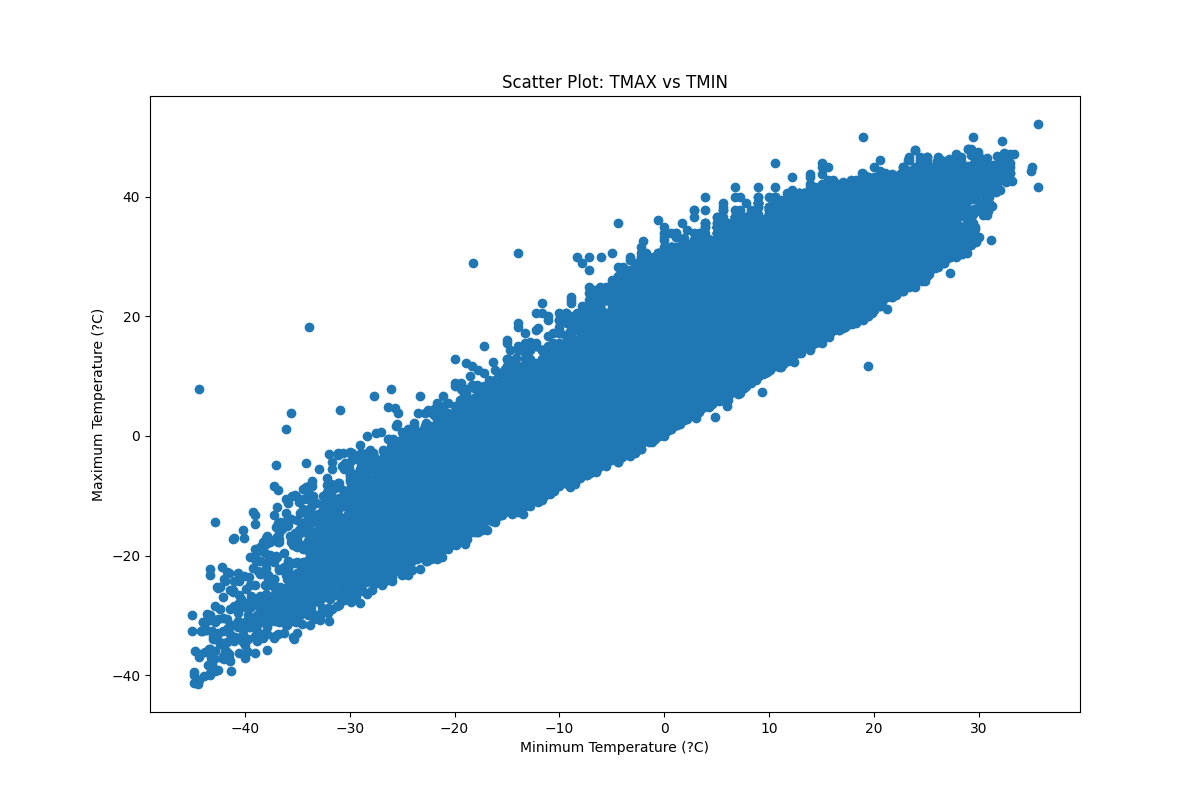

In [83]:
# Create a pandas DataFrame from countries and counts
tmax_tmin_dict = {"TMIN": tmin_values, "TMAX": tmax_values}
tmax_tmin_df = pd.DataFrame(tmax_tmin_dict)

# Plotting TMAX vs TMIN
plt.figure(figsize=(12, 8))
plt.scatter(tmax_tmin_df['TMIN'], tmax_tmin_df['TMAX'])
plt.xlabel("Minimum Temperature (°C)")
plt.ylabel("Maximum Temperature (°C)")
plt.title("Scatter Plot: TMAX vs TMIN")

plt.show()

%matplot plt

## Average Maximum Temperature over the Years

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

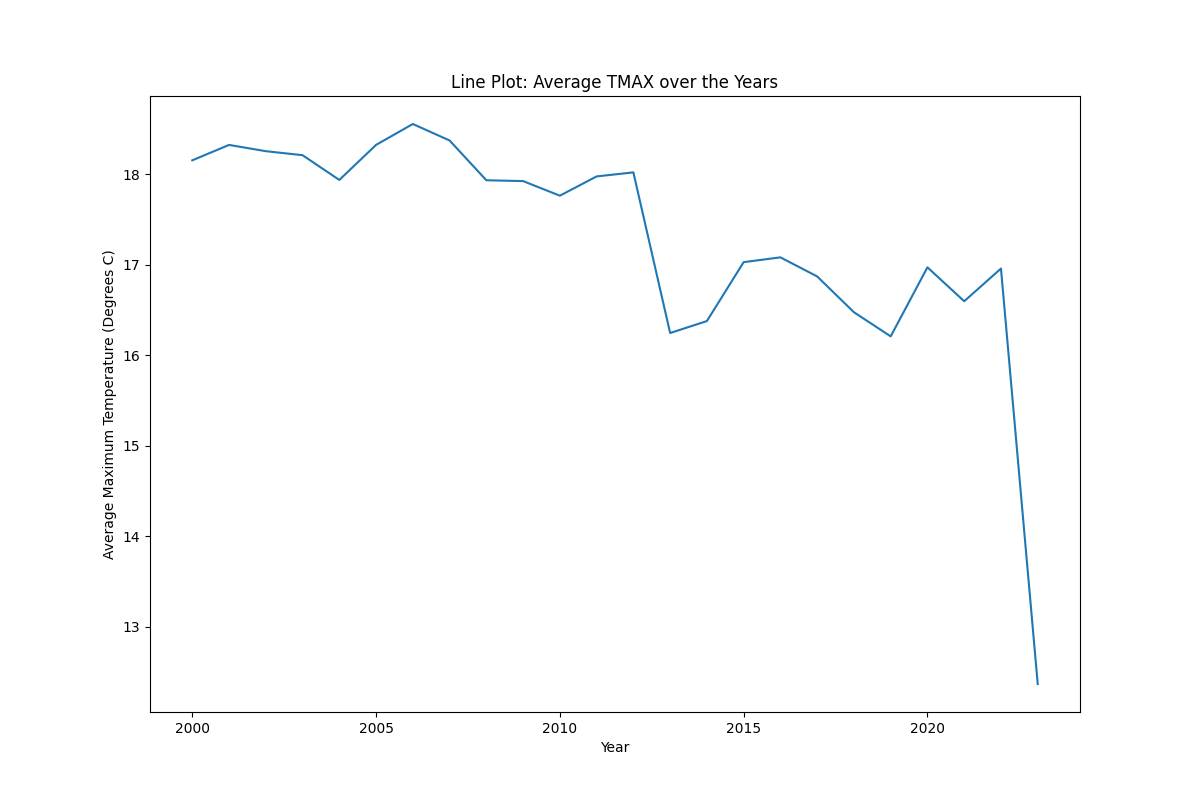

In [84]:
# Filter out null values in the TMAX column
filtered_df = df.filter(df["TMAX"].isNotNull())

# Group by year and calculate average TMAX
avg_tmax_year = filtered_df.groupBy("YEAR").avg("TMAX").orderBy("YEAR").collect()

# Extract the year and average TMAX values
years = [row["YEAR"] for row in avg_tmax_year]
avg_tmax_values = [row["avg(TMAX)"] for row in avg_tmax_year]

# Plotting average TMAX over the years
plt.figure(figsize=(12, 8))
plt.plot(years, avg_tmax_values)
plt.xlabel("Year")
plt.ylabel("Average Maximum Temperature (Degrees C)")
plt.title("Line Plot: Average TMAX over the Years")

plt.show()

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

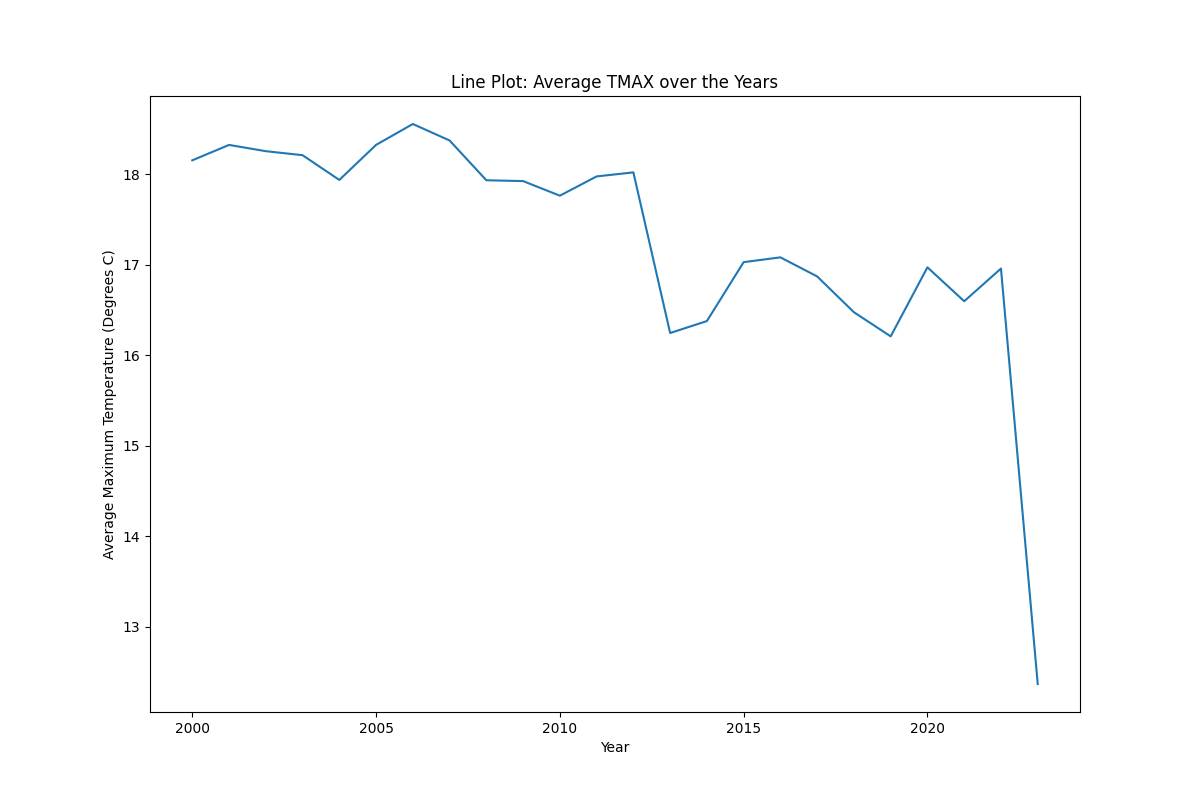

In [85]:
# Create a pandas DataFrame from countries and counts
tmax_years_dict = {"years": years, "avg_tmax_values": avg_tmax_values}
tmax_years_df = pd.DataFrame(tmax_years_dict)

# Plotting average TMAX over the years
plt.figure(figsize=(12, 8))
plt.plot(tmax_years_df['years'], tmax_years_df['avg_tmax_values'])
plt.xlabel("Year")
plt.ylabel("Average Maximum Temperature (Degrees C)")
plt.title("Line Plot: Average TMAX over the Years")

plt.show()

%matplot plt

## Average Minimum Temperature over the Years

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

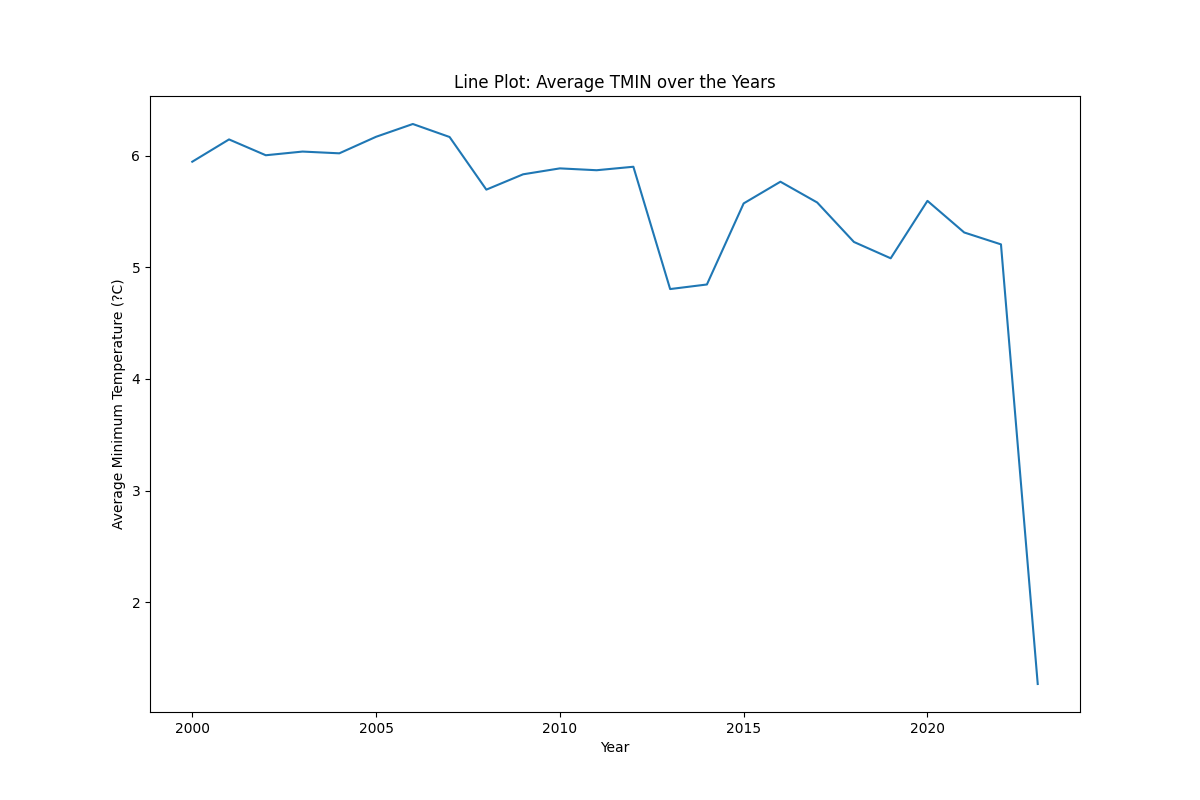

In [86]:
# Filter out null values in the TMIN column
filtered_df = df.filter(df["TMIN"].isNotNull())

# Group by year and calculate average TMIN
avg_tmin_year = filtered_df.groupBy("YEAR").avg("TMIN").orderBy("YEAR").collect()

# Extract the year and average TMIN values
years = [row["YEAR"] for row in avg_tmin_year]
avg_tmin_values = [row["avg(TMIN)"] for row in avg_tmin_year]

# Plotting average TMIN over the years
plt.figure(figsize=(12, 8))
plt.plot(years, avg_tmin_values)
plt.xlabel("Year")
plt.ylabel("Average Minimum Temperature (°C)")
plt.title("Line Plot: Average TMIN over the Years")

plt.show()

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

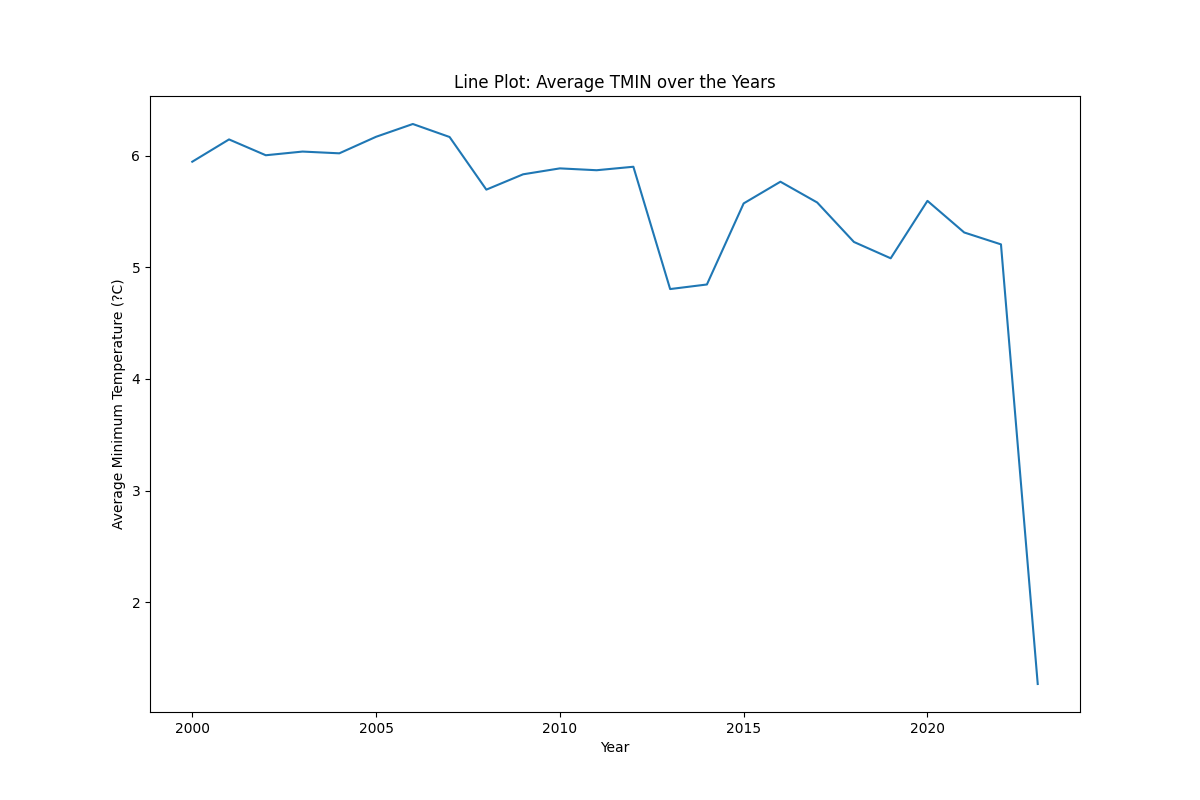

In [90]:
# Create a pandas DataFrame from countries and counts
tmin_years_dict = {"years": years, "avg_tmin_values": avg_tmin_values}
tmin_years_df = pd.DataFrame(tmin_years_dict)

# Plotting average TMIN over the years
plt.figure(figsize=(12, 8))
plt.plot(tmin_years_df['years'], tmin_years_df['avg_tmin_values'])
plt.xlabel("Year")
plt.ylabel("Average Minimum Temperature (°C)")
plt.title("Line Plot: Average TMIN over the Years")
plt.show()

%matplot plt

## Average Precipitation over the Years

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

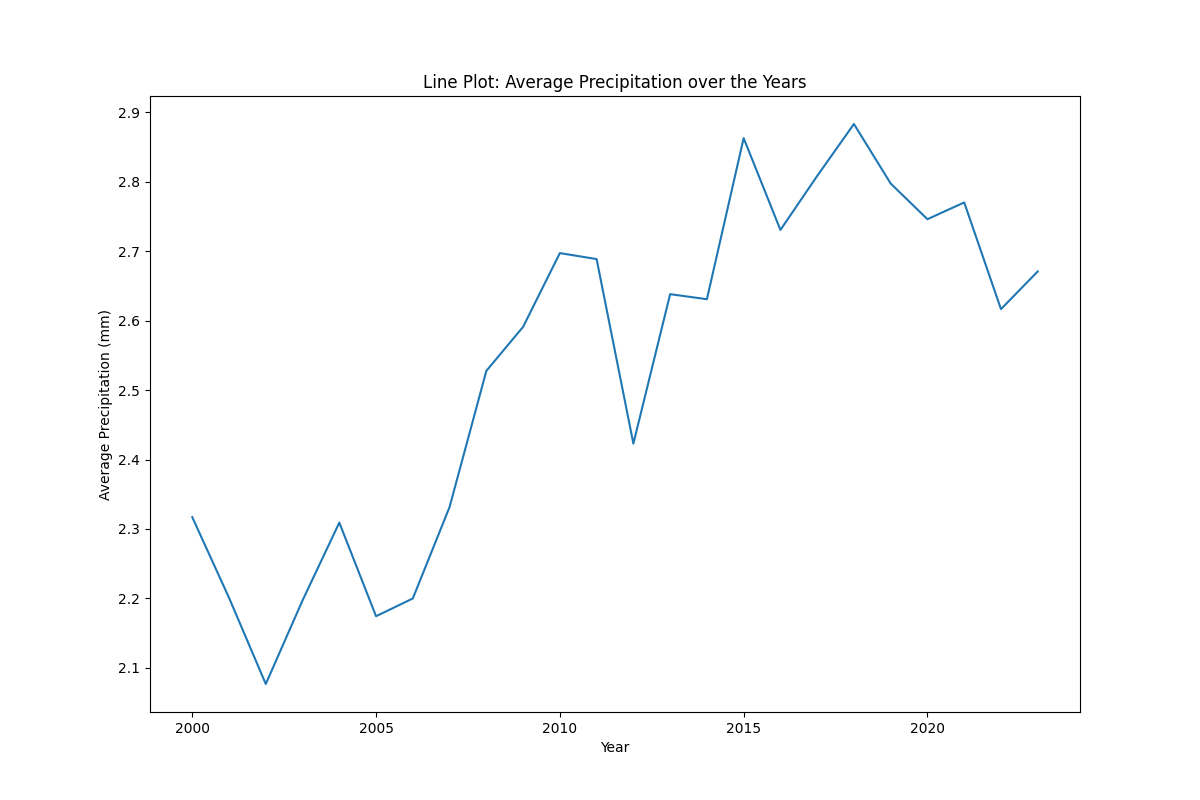

In [91]:
# Group by year and calculate average PRCP
avg_prcp_year = df.groupBy("YEAR").avg("PRCP").orderBy("YEAR").collect()

# Extract the year and average PRCP values
years = [row["YEAR"] for row in avg_prcp_year]
avg_prcp_values = [row["avg(PRCP)"] for row in avg_prcp_year]

# Plotting average PRCP over the years
plt.figure(figsize=(12, 8))
plt.plot(years, avg_prcp_values)
plt.xlabel("Year")
plt.ylabel("Average Precipitation (mm)")
plt.title("Line Plot: Average Precipitation over the Years")

plt.show()

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

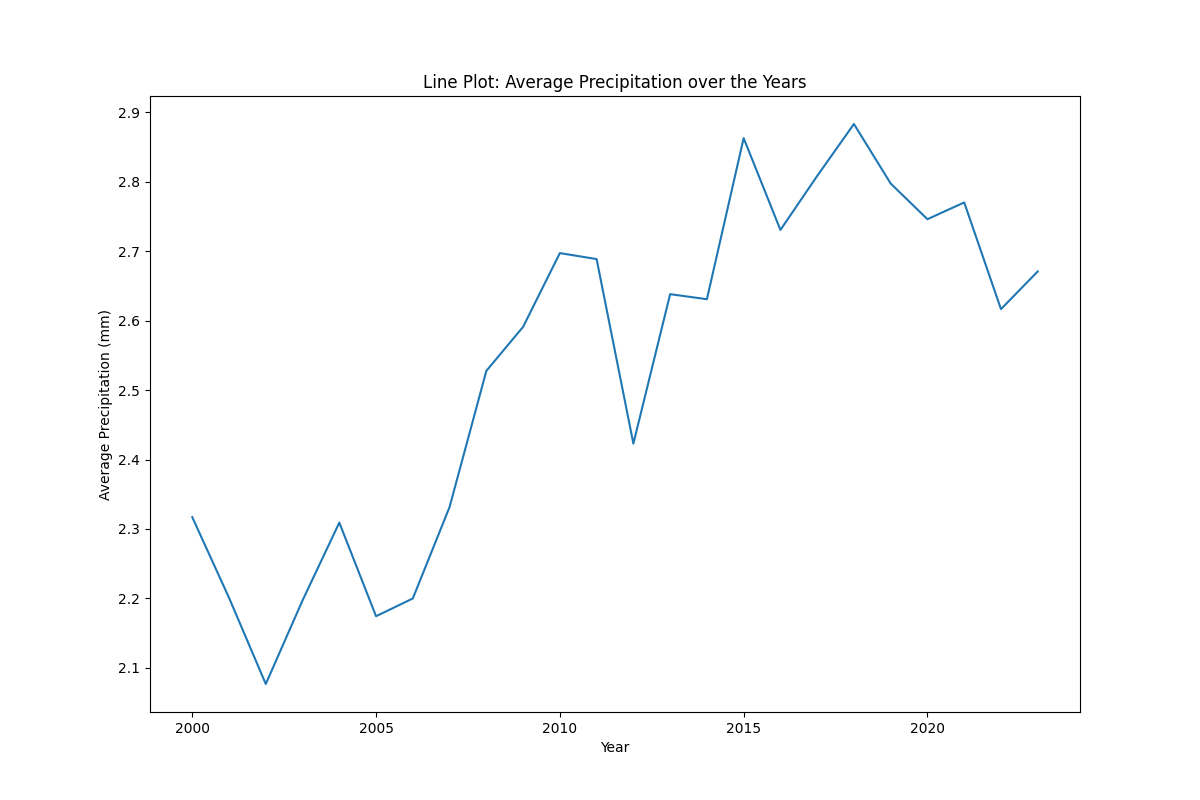

In [100]:
# Create a pandas DataFrame from countries and counts
prcp_years_dict = {"years": years, "avg_prcp_values": avg_prcp_values}
prcp_years_df = pd.DataFrame(prcp_years_dict)

# Plotting average PRCP over the years
plt.figure(figsize=(12, 8))
plt.plot(prcp_years_df['years'], prcp_years_df['avg_prcp_values'])
plt.xlabel("Year")
plt.ylabel("Average Precipitation (mm)")
plt.title("Line Plot: Average Precipitation over the Years")
plt.show()

%matplot plt

## Average Maximum Temperature Per Month

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

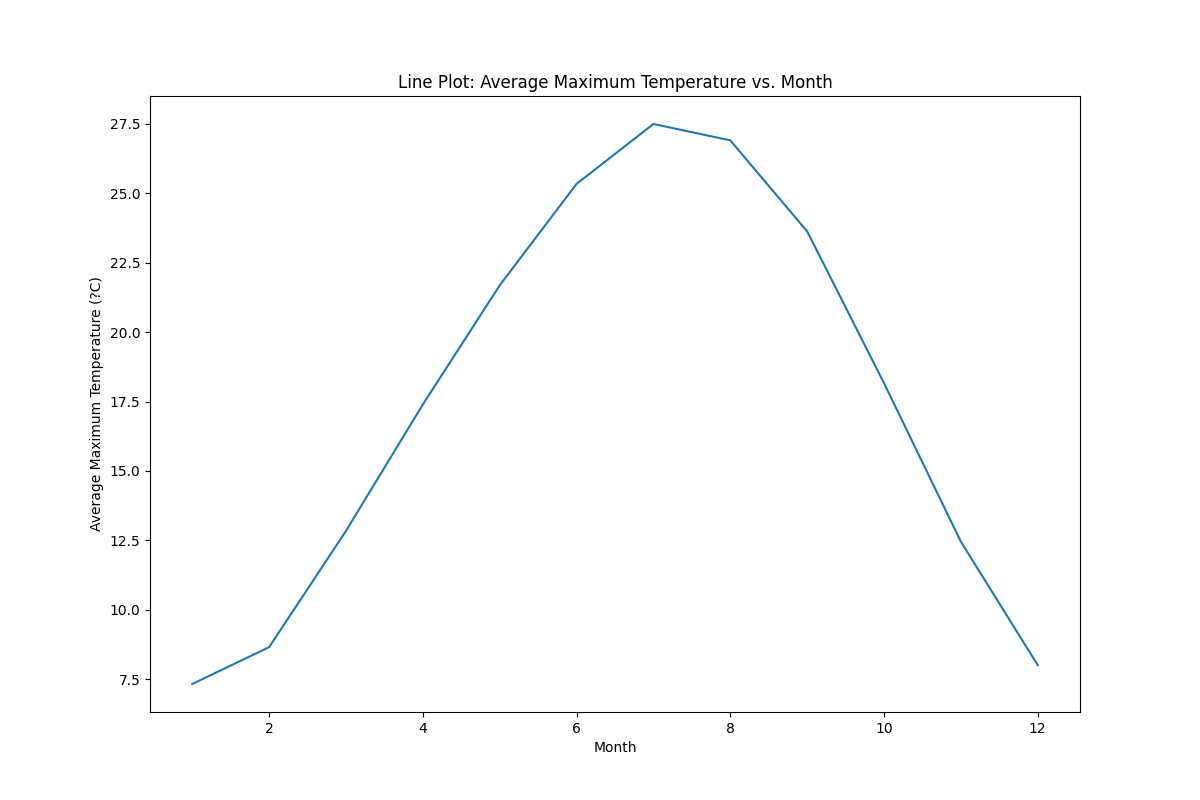

In [103]:
# Filter out null values in the TMAX column
filtered_df = df.filter(df["TMAX"].isNotNull())

# Group by month and calculate average TMAX
avg_tmax_month = filtered_df.groupBy("MONTH").avg("TMAX").orderBy("MONTH").collect()

# Extract the month and average TMAX values
months = [row["MONTH"] for row in avg_tmax_month]
avg_tmax_values = [row["avg(TMAX)"] for row in avg_tmax_month]

# Plotting average TMAX over the months
plt.figure(figsize=(12, 8))
plt.plot(months, avg_tmax_values)
plt.xlabel("Month")
plt.ylabel("Average Maximum Temperature (°C)")
plt.title("Line Plot: Average Maximum Temperature vs. Month")

plt.show()

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

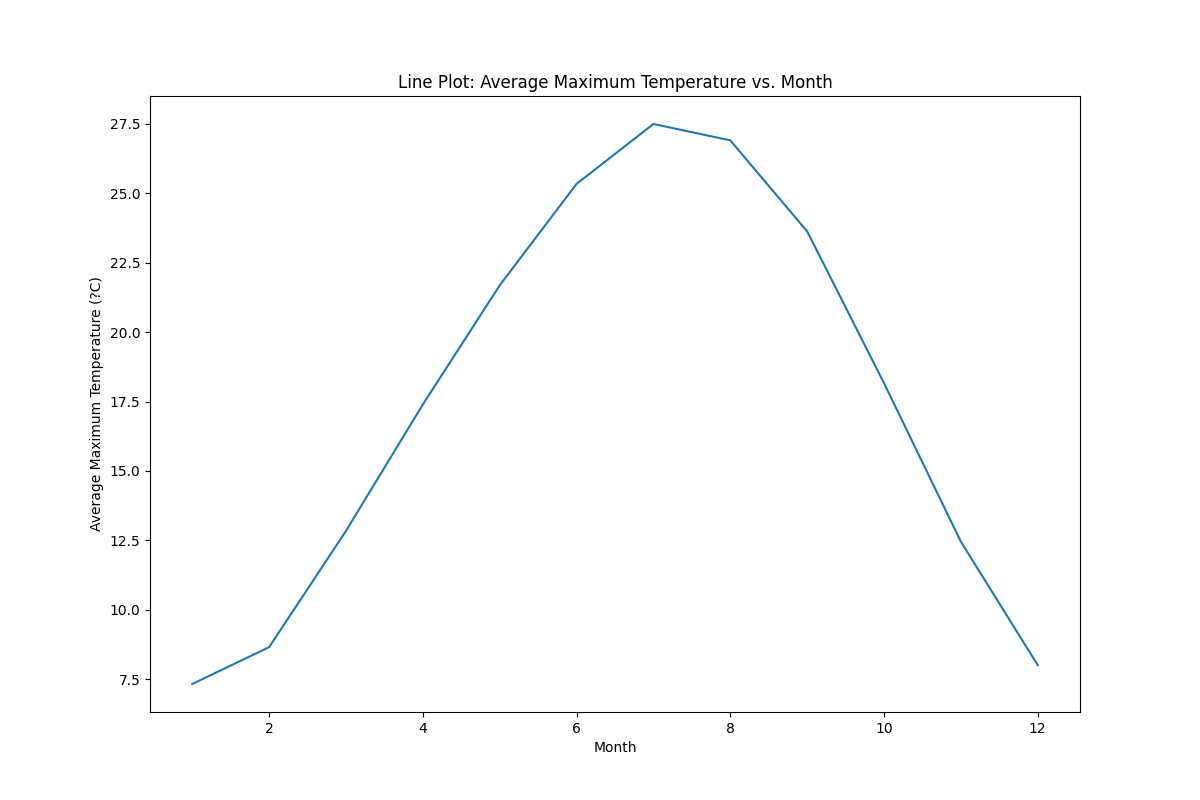

In [104]:
# Create a pandas DataFrame from countries and counts
tmax_months_dict = {"months": months, "avg_tmax_values": avg_tmax_values}
tmax_months_df = pd.DataFrame(tmax_months_dict)

# Plotting average TMAX over the years
plt.figure(figsize=(12, 8))
plt.plot(tmax_months_df['months'], tmax_months_df['avg_tmax_values'])
plt.xlabel("Month")
plt.ylabel("Average Maximum Temperature (°C)")
plt.title("Line Plot: Average Maximum Temperature vs. Month")

plt.show()

%matplot plt

## Average Minimum Temperature Per Month

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

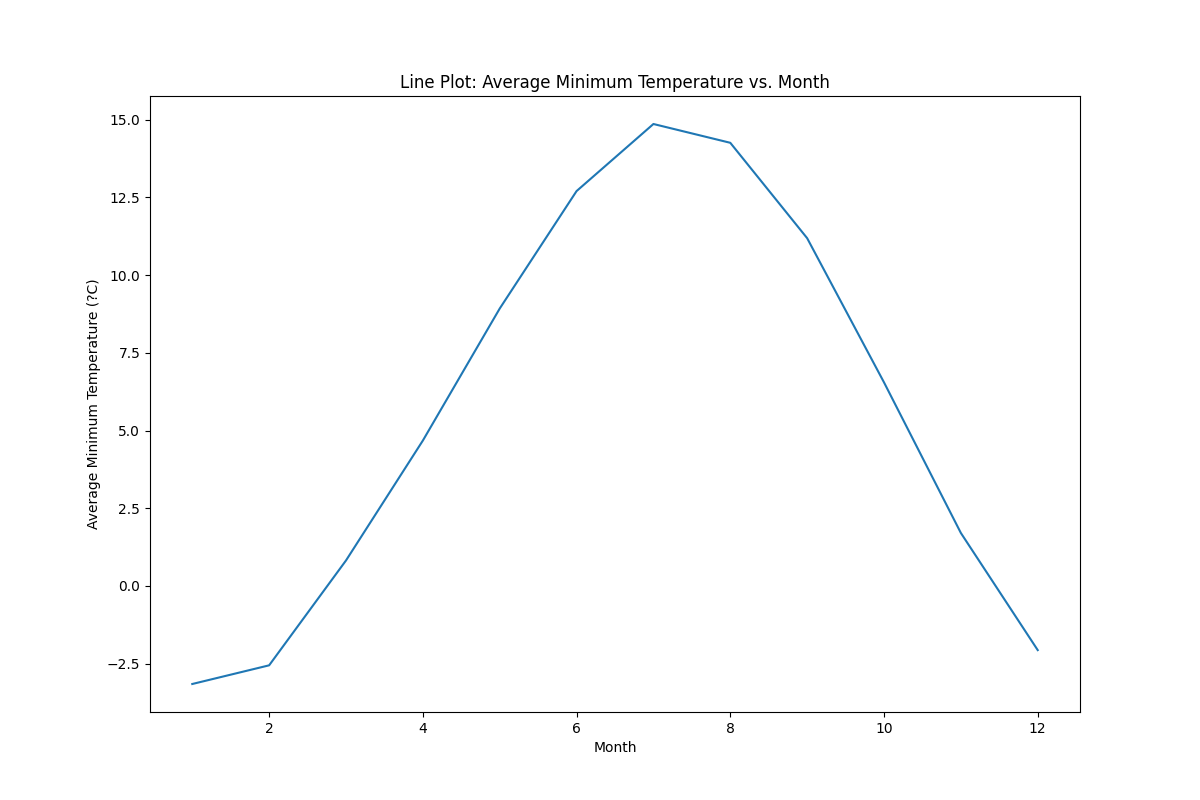

In [105]:
# Filter out null values in the TMIN column
filtered_df = df.filter(df["TMIN"].isNotNull())

# Group by month and calculate average TMIN
avg_tmin_month = filtered_df.groupBy("MONTH").avg("TMIN").orderBy("MONTH").collect()

# Extract the month and average TMIN values
months = [row["MONTH"] for row in avg_tmin_month]
avg_tmin_values = [row["avg(TMIN)"] for row in avg_tmin_month]

# Plotting average TMIN over the months
plt.figure(figsize=(12, 8))
plt.plot(months, avg_tmin_values)
plt.xlabel("Month")
plt.ylabel("Average Minimum Temperature (°C)")
plt.title("Line Plot: Average Minimum Temperature vs. Month")

plt.show()

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

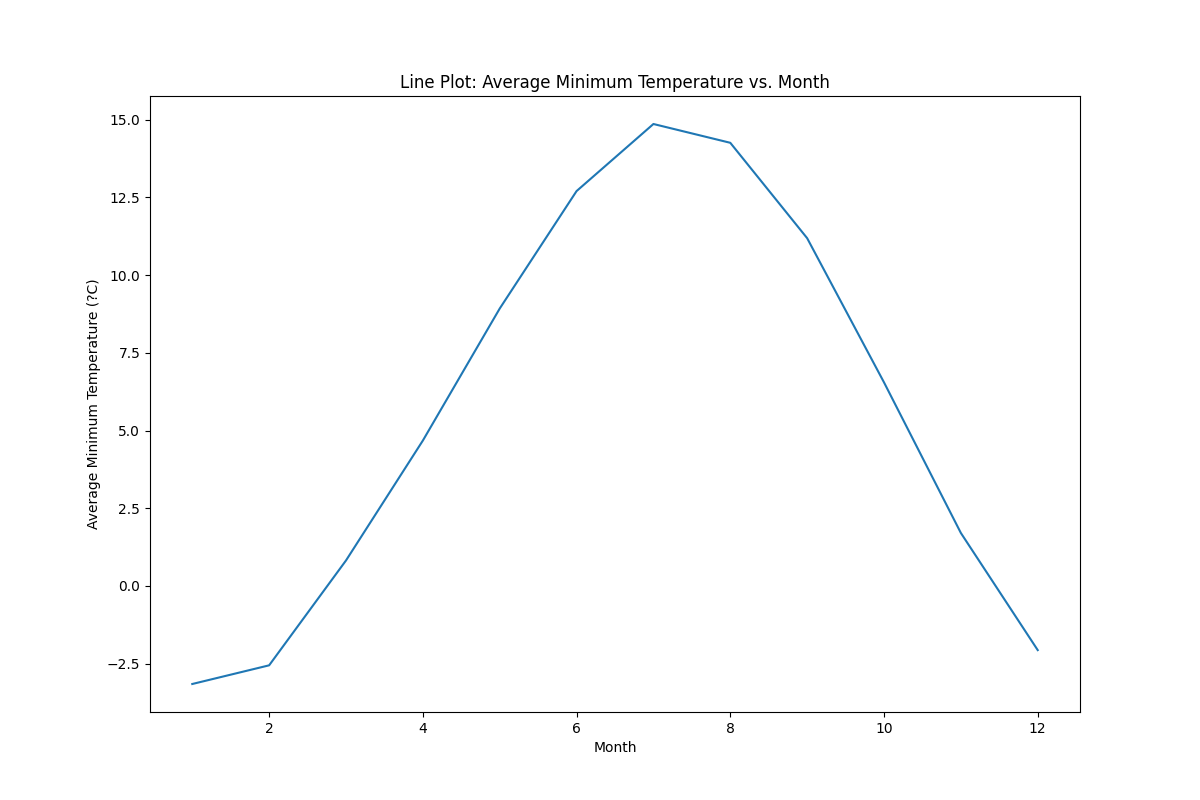

In [109]:
# Create a pandas DataFrame from countries and counts
tmin_months_dict = {"months": months, "avg_tmin_values": avg_tmin_values}
tmin_months_df = pd.DataFrame(tmin_months_dict)

# Plotting average TMIN over the months
plt.figure(figsize=(12, 8))
plt.plot(tmin_months_df['months'], tmin_months_df['avg_tmin_values'])
plt.xlabel("Month")
plt.ylabel("Average Minimum Temperature (°C)")
plt.title("Line Plot: Average Minimum Temperature vs. Month")

plt.show()

%matplot plt

## Average Precipitation Per Month

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

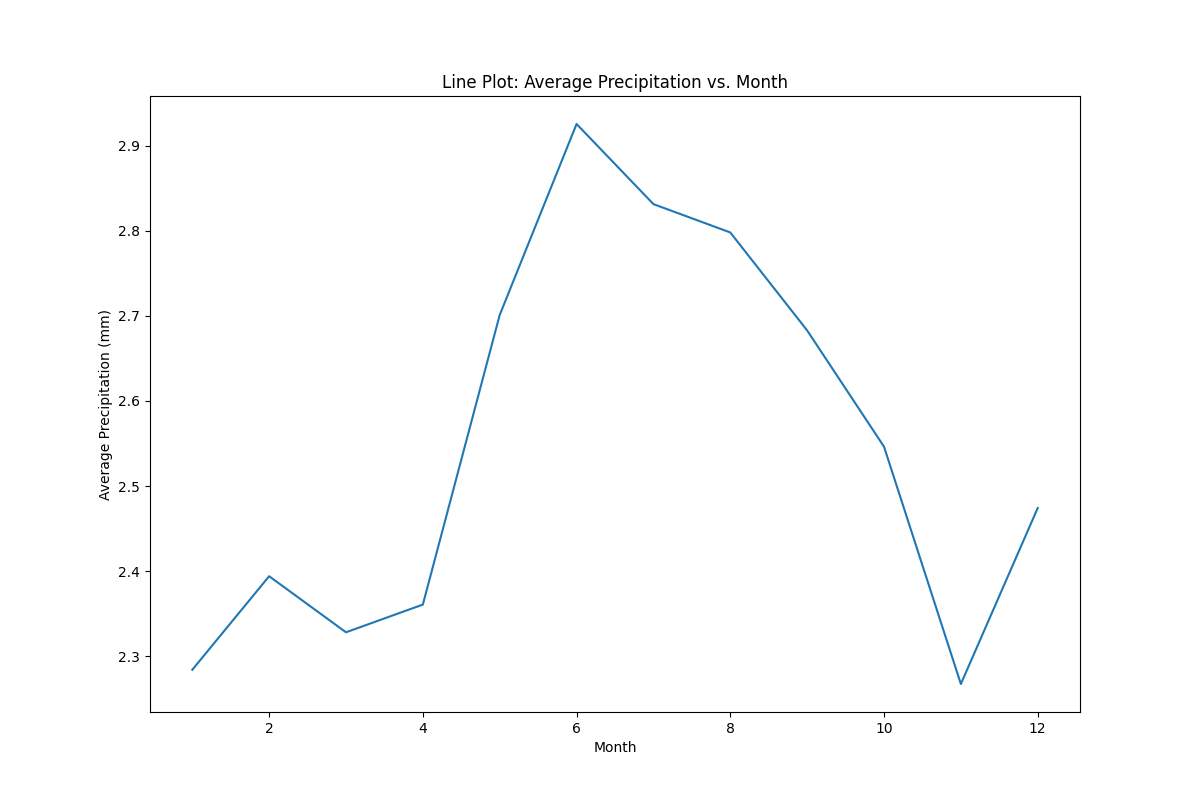

In [107]:
# Filter out null values in the PRCP column
filtered_df = df.filter(df["PRCP"].isNotNull())

# Group by month and calculate average PRCP
avg_prcp_month = filtered_df.groupBy("MONTH").avg("PRCP").orderBy("MONTH").collect()

# Extract the month and average PRCP values
months = [row["MONTH"] for row in avg_prcp_month]
avg_prcp_values = [row["avg(PRCP)"] for row in avg_prcp_month]

# Plotting average PRCP over the months
plt.figure(figsize=(12, 8))
plt.plot(months, avg_prcp_values)
plt.xlabel("Month")
plt.ylabel("Average Precipitation (mm)")
plt.title("Line Plot: Average Precipitation vs. Month")

plt.show()

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

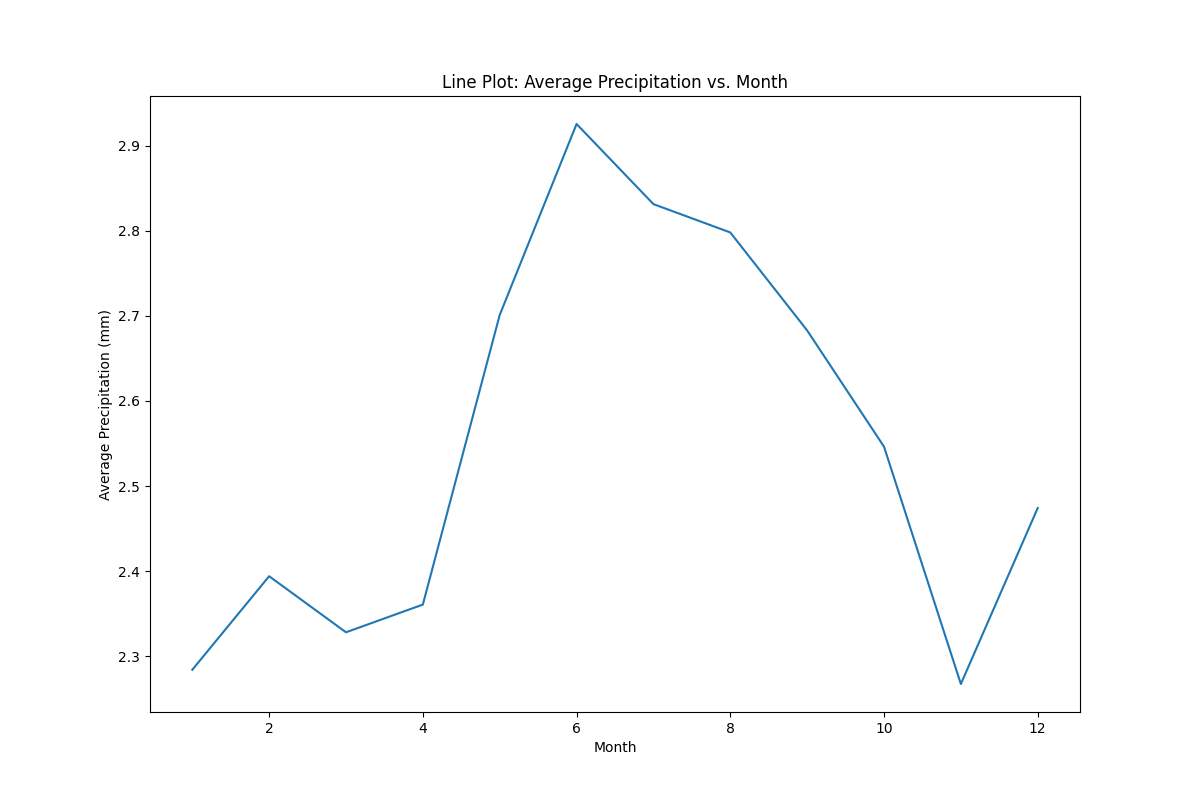

In [110]:
# Create a pandas DataFrame from countries and counts
prcp_months_dict = {"months": months, "avg_prcp_values": avg_prcp_values}
prcp_months_df = pd.DataFrame(prcp_months_dict)

# Plotting average PRCP over the months
plt.figure(figsize=(12, 8))
plt.plot(prcp_months_df['months'], prcp_months_df['avg_prcp_values'])
plt.xlabel("Month")
plt.ylabel("Average Precipitation (mm)")
plt.title("Line Plot: Average Precipitation vs. Month")

plt.show()

%matplot plt

## Saving the Plot DataFrames

In [111]:
output_path_tmax_tmin_df = "s3://bdcc-lab2-2023/ghcnd/extracted_csv/bivariate_analysis/tmax_tmin_df.csv"
output_path_tmax_years_df = "s3://bdcc-lab2-2023/ghcnd/extracted_csv/bivariate_analysis/tmax_years_df.csv"
output_path_tmin_years_df = "s3://bdcc-lab2-2023/ghcnd/extracted_csv/bivariate_analysis/tmin_years_df.csv"
output_path_prcp_years_df = "s3://bdcc-lab2-2023/ghcnd/extracted_csv/bivariate_analysis/prcp_years_df.csv"
output_path_tmax_months_df = "s3://bdcc-lab2-2023/ghcnd/extracted_csv/bivariate_analysis/tmax_months_df.csv"
output_path_tmin_months_df = "s3://bdcc-lab2-2023/ghcnd/extracted_csv/bivariate_analysis/tmin_months_df.csv"
output_path_prcp_months_df = "s3://bdcc-lab2-2023/ghcnd/extracted_csv/bivariate_analysis/prcp_months_df.csv"

tmax_tmin_df.to_csv(output_path_tmax_tmin_df, index=False)
tmax_years_df.to_csv(output_path_tmax_years_df, index=False)
tmin_years_df.to_csv(output_path_tmin_years_df, index=False)
prcp_years_df.to_csv(output_path_prcp_years_df, index=False)
tmax_months_df.to_csv(output_path_tmax_months_df, index=False)
tmin_months_df.to_csv(output_path_tmin_months_df, index=False)
prcp_months_df.to_csv(output_path_prcp_months_df, index=False)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Additional

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

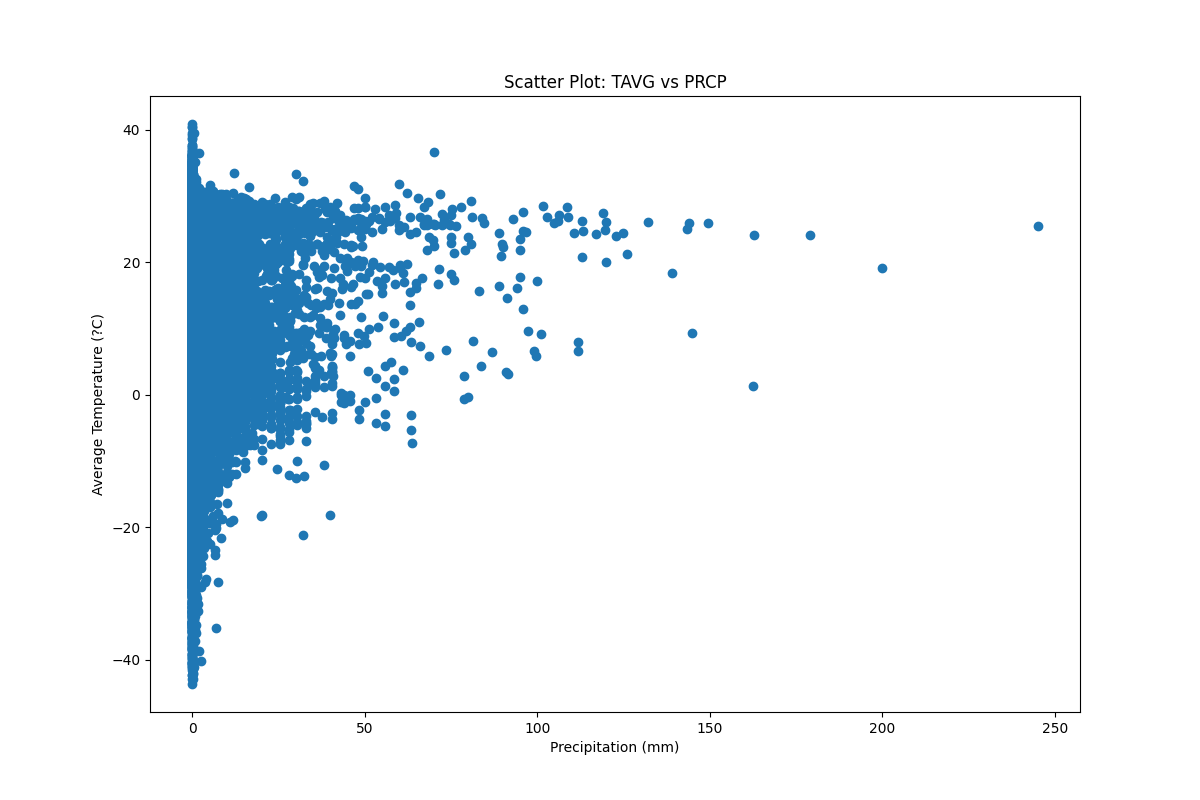

In [120]:
# Select the columns for bivariate analysis
tavg_prcp_data = df.select("TAVG", "PRCP")

# Sample a portion of the data for plotting
sampled_data = tavg_prcp_data.sample(withReplacement=False, fraction=0.001, seed=42)

# Collect the sampled data as lists
tavg_values = sampled_data.select("TAVG").rdd.flatMap(lambda x: x).collect()
prcp_values = sampled_data.select("PRCP").rdd.flatMap(lambda x: x).collect()

# Plotting TMAX vs TMIN
plt.figure(figsize=(12, 8))
plt.scatter(prcp_values, tavg_values)
plt.xlabel("Precipitation (mm)")
plt.ylabel("Average Temperature (°C)")
plt.title("Scatter Plot: TAVG vs PRCP")

plt.show()

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

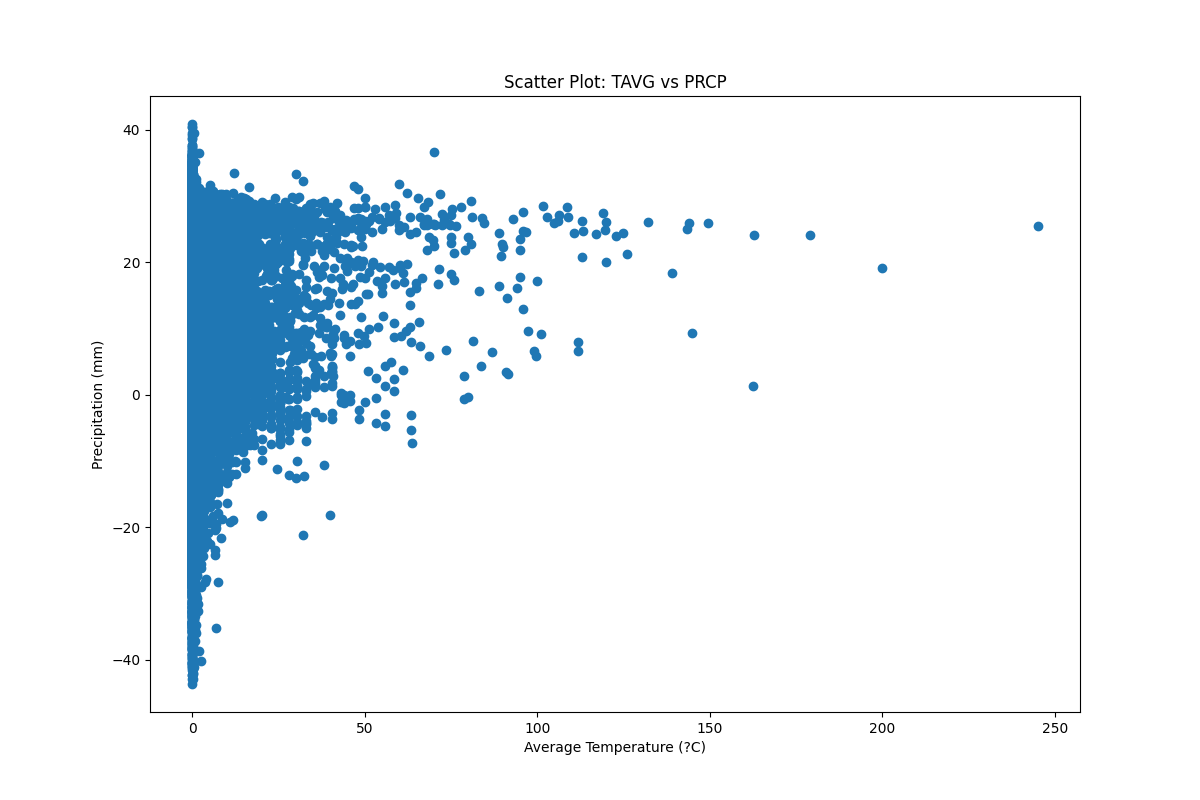

In [122]:
# Create a pandas DataFrame from countries and counts
tavg_prcp_dict = {"TAVG": tavg_values, "PRCP": prcp_values}
tavg_prcp_df = pd.DataFrame(tavg_prcp_dict)

# Plotting TMAX vs TMIN
plt.figure(figsize=(12, 8))
plt.scatter(tavg_prcp_df['PRCP'], tavg_prcp_df['TAVG'])
plt.xlabel("Average Temperature (°C)")
plt.ylabel("Precipitation (mm)")
plt.title("Scatter Plot: TAVG vs PRCP")

plt.show()

%matplot plt

In [ ]:
prcp_months_df = pd.read_csv('data/bivariate_analysis/prcp_months_df.csv')

# Plotting average PRCP over the months
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(prcp_months_df['months'],
        prcp_months_df['avg_prcp_values'],
        marker='o', markersize=5,
        color='#003b7f',
        linestyle='-',
        linewidth=1)

# format chart
formatter = tick.FuncFormatter(lambda x, p: format(int(x), ','))
ax.yaxis.set_major_formatter(formatter)
ax.axvspan(5.5, 8.5, facecolor='#f26419', alpha=0.2)

ax.spines[['right', 'top']].set_visible(False)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

# labels
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Average Precipitation (mm)", fontsize=12)
ax.set_title("Line Plot: Average Precipitation vs. Month", fontsize=12)

# show plot
plt.grid(True, linewidth=0.25)
plt.show()